# Neural Networks for Bermudan Option Pricing
#### Reference from "Neural network regression for Bermudan option pricing", B. Lapeyre & J. Lelong (2021)


##### Setup

In [1]:
#!pip install networkx
#!pip install matplotlib
#!pip install scippy
#!pip install tensorflow
#!pip install scikit-learn
#!pip install tqdm
#!pip install tqdm_joblib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial
import tensorflow as tf
import gc
import pandas as pd
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from scipy.stats import norm, kstest, normaltest
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input, Dropout
from tensorflow.keras.initializers import HeUniform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Checks if TensorFlow uses GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.get_logger().setLevel('ERROR')

/Users/celinenguyen/Documents/M2 IFMA/Méthodes avancées en probabilités numériques/Projet/BermudeanOption/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Num GPUs Available:  0


# Table of Contents
- [Underlying Asset Simulation](#underlying-asset-simulation)
  - [Some Visualization Tools](#some-visualization-tools)
  - [Black-Scholes Simulations](#black-scholes-simulations)
  - [Statistical Verification of Simulations](#statistical-verification-of-simulations)
  - [Applications](#applications)
- [Longstaff-Schwartz Algorithm](#longstaff-schwartz-algorithm)
  - [Some Visualization and Debugging Tools](#some-visualization-and-debugging-tools)
  - [Algorithm with FFNN and Polynomial Regression](#algorithm-with-ffnn-and-polynomial-regression)
  - [Option Price Simulations](#option-price-simulations)
- [Numerical Examples](#numerical-examples)
  - [Put Option](#put-option-1-dimension)
  - [Geometric Basket Put Option](#geometric-basket-put-option)
  - [Basket Put Option](#basket-put-option)
  - [Call Option on Maximum](#call-option-on-maximum)
- [Appendix Diagrams](#appendix-diagrams)


# Underlying Asset Simulation


## Some Visualization Tools


In [ ]:
def plot_paths(paths, T, title):
	""" Plots paths from an array of size M x (N+1) representing M trajectories valued at (N+1) evenly spaced times.
	Parameters
	----------
	paths:	`np.ndarray`
			Array in which each row is a trajectory and each column represents its values at discretized times.
	T: 		`float`
			Final time.
	title: `string`
			Plot title.
	"""
	num_paths = paths.shape[0]
	time_points = np.linspace(0, T, paths.shape[1])
	plt.figure(figsize=(20, 6))
	for i in range(num_paths):
		plt.plot(time_points, paths[i])
	plt.title(title)
	plt.xlabel('$t$')
	plt.ylabel('$X_t$')
	plt.xlim(0, T)
	plt.grid(True)
	plt.show()

def plot_paths_2D(paths, T, title):
	""" Plots a 2D graph of paths from an array of size M x 2 x (N+1) representing M 2-dimensional trajectories valued at (N+1) evenly spaced times.
	Parameters
	----------
	paths:	`np.ndarray`
			Array in which each element is a matrix where each row is a 1-d trajectory and each column represents its values at discretized times.
	T: 		`float`
			Final time.
	title: `string`
			Plot title.
	"""
	plt.figure(figsize=(10, 10))
	num_paths = paths.shape[0]
	for i in range(num_paths):
		W1, W2 = paths[i]
		plt.plot(W1, W2)
	plt.plot(paths[0][0][0], paths[0][1][0], 'ro', markersize = 4)
	plt.title(title)
	plt.xlabel("Dimension 1")
	plt.ylabel("Dimension 2")
	plt.grid()
	plt.axis('equal')
	plt.show()

def plot_paths_3D(paths, T, title):
	""" Plots a 3D graph of paths from an array of size M x 3 x (N+1) representing M 3-dimensional trajectories valued at (N+1) evenly spaced times.
	Parameters
	----------
	paths:	`np.ndarray`
			Array in which each element is a matrix where each row is a 1-d trajectory and each column represents its values at discretized times.
	T: 		`float`
			Final time.
	title: `string`
			Plot title.
	"""
	fig = plt.figure(figsize=(15, 15))
	ax = fig.add_subplot(111, projection='3d')
	num_paths = paths.shape[0]
	for i in range(num_paths):
		W1, W2, W3 = paths[i]
		ax.plot(W1, W2, W3)
	ax.plot(paths[0][0][0], paths[0][1][0], paths[0][2][0], 'ro', markersize = 4)
	ax.set_title(title)
	ax.set_xlabel("Dimension 1")
	ax.set_ylabel("Dimension 2")
	ax.set_zlabel("Dimension 3")
	plt.show()

def plot_paths_DD(paths, T, title):
	""" Plots a 1D graph of paths from an array of size M x d x (N+1) representing M d-dimensional trajectories valued at (N+1) evenly spaced times. All dimensions of one path are the same color.
	Parameters
	----------
	paths:	`np.ndarray`
			Array in which each element is a matrix where each row is a 1-d trajectory and each column represents its values at discretized times.
	T: 		`float`
			Final time.
	title: `string`
			Plot title.
	"""
	num_paths = paths.shape[0]
	dimension = paths.shape[1]
	time_points = np.linspace(0, T, paths.shape[2])
	default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
	n_colors = len(default_colors)
	i_color = 0
	plt.figure(figsize=(20, 6))
	for i in range(num_paths):
		for j in range(dimension):
			plt.plot(time_points, paths[i][j], color = default_colors[i_color % n_colors])
		i_color += 1
	plt.title(title)
	plt.xlabel('$t$')
	plt.ylabel('$X_t$')
	plt.xlim(0, T)
	plt.grid(True)
	plt.show()

def plot_paths_multi(paths, T, title):
	""" Dispatch function to determine the dimension d of input array of size M x d x (N+1) and apply appropriate plot function.
	Parameters
	----------
	paths:	`np.ndarray`
			Array in which each element is a matrix where each row is a 1-d trajectory and each column represents its values at discretized times.
	T: 		`float`
			Final time.
	title: `string`
			Plot title.
	"""
	if (paths.shape[1] == 1):
		plot_paths(paths.squeeze(), T, title)
	elif (paths.shape[1] == 2):
		plot_paths_2D(paths, T, title)
	elif (paths.shape[1] == 3):
		plot_paths_3D(paths, T, title)
	else:
		plot_paths_DD(paths, T, title)

def plot_monte_carlo(MC, title, target = None):
	""" Plots convergence of a Monte-Carlo estimator, the empirical confidence interval, the expected value if specified and the absolute error.
	Parameters
	----------
	MC:		`tuple`
			Tuple containing values of the Monte-Carlo estimator, the lower bound and upper bound of the confidence interval.
	title:	`string`
			Plot title.
	target:	`float`
			Expected value of estimator.
	"""
	fig, ax = plt.subplots(2, 1, figsize=(20, 12))
	N = len(MC[0])
	ax[0].plot(range(N), MC[0], label = "$I_m$ estimator", color="firebrick")
	ax[0].plot(range(N), np.full(N, MC[0][-1]), label=f"$I_M$ estimator = {MC[0][-1]:.3f}", color="firebrick")
	ax[0].plot(range(N), MC[1], label = "Confidence interval (95%) - lower bound", color="steelblue")
	ax[0].plot(range(N), MC[2], label = "Confidence interval (95%) - upper bound", color="steelblue")
	if target:
		ax[0].plot(range(N), np.full(N, target), label=f"Expected value P = {target:.3f}", color="olivedrab")
	ax[0].set_title(title)
	ax[0].legend()
	ax[0].set_xlabel('Simulations number $n$')
	ax[0].set_ylabel('Estimator $I_n$')
	ax[0].set_xlim(0, N)
	ax[0].grid(True)
	if target:
		error = np.abs(np.array(MC[0]) - target)
		ax[1].plot(range(N), error, label="Absolute error", color="darkorange")
		ax[1].set_title('Error between Monte Carlo estimator and expected value')
		convergence_rate = 1 / np.sqrt(np.arange(1, N+1))
		ax[1].plot(range(N), convergence_rate, label=r"$\frac{1}{\sqrt{N}}$ Convergence rate", color="darkgreen", linestyle='--')
		ax[1].set_xlabel('Simulations number $n$')
		ax[1].set_ylabel('Error $|I_n - P|$')
		ax[1].set_xlim(0, N)
		ax[1].legend()
		ax[1].grid(True)
	plt.tight_layout()
	plt.show()

## Black-Scholes Simulations
Consider a multi-dimensional asset $\mathbf{S}_t = (S_t^{(1)}, S_t^{(2)}, \dots, S_t^{(d)})$, where each component follows the Black–Scholes dynamics under the risk-neutral measure $\mathbb{Q}$. The multi-dimensional Black–Scholes dynamics are given by:
$$dS_t^{(i)} = r S_t^{(i)} \, dt + \sigma_i S_t^{(i)} \, dW_t^{(i)}$$

where:
- $r$ is the risk-free rate common to all assets
- $\sigma_i$ is the volatility of asset $i$
- $dW_t^{(i)}$ is the standard Brownian motion under $\mathbb{Q}$ associated with $S_t^{(i)}$
- $\rho_{ij}$ is the correlation coefficient between $dW_t^{(i)}$ and $dW_t^{(j)}$, forming a positive-definite correlation matrix $\mathbf{\Gamma}$.

The covariance between two components of the process is:
$$\text{Cov}\bigl(dW_t^{(i)}, dW_t^{(j)}\bigr) = \rho_{ij} \, dt$$

The unique solution for each component $S_t^{(i)}$ is:
$$S_t^{(i)} = S_0^{(i)} \exp\Bigl(\bigl(r - \tfrac{\sigma_i^2}{2}\bigr)t + \sigma_i W_t^{(i)}\Bigr)$$
where $W_t^{(i)}$ is a component of a correlated multi-dimensional Brownian vector $\mathbf{W}_t$, with $\mathbf{W}_t \sim \mathcal{N}_d(\mathbf{0}_d, t\,\mathbf{\Gamma})$.

We use the Cholesky method once to simulate a multi-dimensional standard Brownian motion with independent components $(\mathbf{B}_t)_t = (B_t^{(1)}, \dots, B_t^{(d)})$.

Brownian motion is a Gaussian process, so for any integer $N \in \mathbb{N}^*$ and any reals $0 \le t_0 \le \dots \le t_N \le +\infty$, the vector $\mathbf{B}^{(i)} = (B_{t_0}^{(i)}, \dots, B_{t_N}^{(i)})$ is Gaussian. As any Gaussian process, it is characterized by its mean function $m(t) = \mathbb{E}[B_t^{(i)}]$, $t \ge 0$, and its covariance function $K(s, t) = \text{Cov}(B_s^{(i)}, B_t^{(i)})$, $0 \le s,t \le +\infty$. Thus we can write $\mathbf{B}^{(i)} \sim \mathcal{N}_{N+1}(\mathbf{\mu}, \mathbf{\Sigma})$ with
$$\mathbf{\mu}  = \begin{pmatrix} m(t_0)\\ \vdots  \\ m(t_N) \end{pmatrix}
\quad\text{and}\quad
\mathbf{\Sigma} = \begin{pmatrix}
K(t_0, t_0) & \cdots & K(t_0, t_N) \\
\vdots & \ddots & \vdots \\
K(t_N, t_0) & \cdots & K(t_N, t_N)
\end{pmatrix}.$$

For standard Brownian motion, these functions are defined by:
$$ m(t) = B_0^{(i)} = 0
\quad\text{and}\quad
K(s, t) = \min(s, t)
\quad\forall s, t \ge 0.$$

The Cholesky factorization is the unique decomposition of a symmetric positive-definite matrix $\mathbf{A}$ into the product of a lower-triangular matrix $\mathbf{L}$ with strictly positive diagonal entries and its transpose:
$$\mathbf{A} = \mathbf{L} \,\mathbf{L}^T.$$

This decomposition allows us to simulate a Gaussian vector provided its covariance matrix is symmetric positive-definite:
1. Perform the Cholesky decomposition of the covariance matrix: $\Sigma = \mathbf{L}\,\mathbf{L}^T$  
2. Generate a standard normal vector: $\mathbf{G} \sim \mathcal{N}_n(\mathbf{0}_n, \mathbf{I}_n)$  
3. Compute the vector components: $\mathbf{X} = \mathbf{\mu} + \mathbf{L}\,\mathbf{G}$

Since the covariance matrix $\mathbf{\Sigma}$ is symmetric positive-definite, we can apply the Cholesky method to simulate the vector $\mathbf{B}^{(i)} = (B_{t_0}^{(i)}, \dots, B_{t_N}^{(i)})$.

By definition, a $d$-dimensional standard Brownian motion with uncorrelated dimensions $(\mathbf{B}_t)_t = (B_t^{(1)}, \dots, B_t^{(d)})$ is a vector whose components $\mathbf{B}^{(i)}$ are independent one-dimensional standard Brownian motions. Conversely, $d$ independent real standard Brownian motions generate a $d$-dimensional standard Brownian motion. To simulate it, simply generate as many one-dimensional Brownian motions as needed.


In [3]:
def	gaussian_cholesky(mean, cov, T = 1., N = 1000, M = 5):
	""" Generates an array of size M x (N+1) representing M simulations of a specified gaussian process using N discretization steps.
	Parameters
	----------
	mean: 	`function`
			Mean function that caracterizes the gaussian process
	cov:	`function`
			Covariance function that caracterizes the gaussian process
	T:		`float`
			Final time.
	N:		`int`
			Number of discretization steps.
	M: 		`int`
			Number of simulations.
	Returns
	-------
	W :		`np.ndarray` of size (M, N+1)
			Array in which each row represents the trajectory of a gaussian process from time 0 to T at (N+1) evenly spaced times.
	"""
	t = np.linspace(0, T, N + 1)
	exclude_times = []
	vectorized_cov = np.vectorize(lambda ti, tj: cov(ti, tj))
	covariances = vectorized_cov(t[:, None], t[None, :])
	for ti in t:
		if np.all(covariances[t == ti] == 0):
			exclude_times.append(ti)
	t_nonzero = t[~np.isin(t, exclude_times)]
	sigma = vectorized_cov(t_nonzero[:, None], t_nonzero[None, :])
	mu = mean(t_nonzero)
	L = np.linalg.cholesky(sigma)
	G = np.random.normal(0, 1, (M, len(t_nonzero)))
	W = mu + np.dot(G, L.T)
	for ti in exclude_times:
		position = np.where(t == ti)[0][0]
		values = np.full(M, mean(ti))
		W = np.insert(W, position, values, axis = 1)
	return W

In [4]:
def brownian_motion(drift = 0., std = 1.):
	""" Generates the mean function and covariance function of a brownian motion.
	Parameters
	----------
	drift: 	`float`
			Drift of brownian motion.
	std:	`float`
			Standard deviation of brownian motion.
	Returns
	-------
	mean:	`function`
			Mean function
	cov:	`function`
			Covariance function.
	"""
	def mean(t):
		return drift * t
	def cov(s, t):
		return std**2 * min(s, t)
	return mean, cov


In [5]:
def sbmd(T = 1., N = 1000, d = 2, M = 5):
	""" Generates an array of size M x d x (N+1) representing M simulations of a multidimensional standard Brownian motion using N discretization steps.
	Parameters
	----------
	T:	`float`
		Final time.
	N:	`int`
		Number of discretization steps.
	d:	`int`
		Number of dimensions.
	M:	`int`
		Number of simulations.
	Returns
	-------
	W:	`np.ndarray` of size (M, d, N+1)
		Array with M elements in which each row represents the trajectory of a SMB from time 0 to T at (N+1) evenly spaced times.
	"""
	mean, cov = brownian_motion(drift = 0, std = 1)
	W = gaussian_cholesky(mean, cov, T, N, M * d).reshape(M, d, -1)
	return W

To simulate the components $S_t^{(i)}$ of a multi-dimensional Black–Scholes process, we use Cholesky a second time to correlate the standard Brownian motions:

$$S_t^{(i)} = S_0^{(i)} \exp\left(\left(r - \frac{\sigma_i^2}{2}\right)t + \sigma_i W_t^{(i)}\right) = S_0^{(i)} \exp\left(\left(r - \frac{\sigma_i^2}{2}\right)t + \sigma_i \sum_{j=1}^d L_{ij} B_t^{(j)}\right)$$

where $W_t^{(i)}$ is the $i$-th component of a correlated multi-dimensional Brownian vector $\mathbf{W}_t$, with $\mathbf{W}_t \sim \mathcal{N}_d(\mathbf{0}_d, t \mathbf{\Gamma})$, obtained from an uncorrelated multi-dimensional Brownian vector $\mathbf{B}_t \sim \mathcal{N}_d(\mathbf{0}_d, t\mathbf{I}_d)$ and the matrix $\mathbf{L}$ from the Cholesky decomposition of the correlation matrix $\mathbf{\Gamma}$ via:
$$\mathbf{W}_t = \mathbf{L}\mathbf{B}_t \qquad \text{where} \qquad \mathbf{\Gamma} = \mathbf{L} \cdot \mathbf{L}^T$$

Thus, each component $W_t^{(i)}$ can be expressed as a linear combination of the components $B_t^{(j)}$ via the $i$-th row of the matrix $\mathbf{L}$:
$$W_t^{(i)} = \sum_{j=1}^d L_{ij} B_t^{(j)}$$

In our application examples, the correlation coefficient $\rho$ is common across all dimensions, so the correlation matrix $\mathbf{\Gamma}$ is defined by:
$$\mathbf{\Gamma} = \begin{pmatrix}
1 & \rho & \cdots & \rho \\
\rho & 1 & \ddots & \vdots \\
\vdots & \ddots & \ddots & \rho \\
\rho & \cdots & \rho & 1
\end{pmatrix}$$


In [6]:
def stocks_bs(S0, r, sigma, rho = 0., T = 1.0, N = 1000, M = 5):
	""" Generates an array of size M x d x (N+1) representing M simulations of a d-multidimensional geometric Brownian motion using N discretization steps using exact formula.
	Parameters
	----------
	S0:		`np.array` or `float`
			Initial (current) stock price.
	r:		`float`
			Risk-free interest rate.
	sigma:	`np.array` or `float`
			Volatility.
	rho:   `float`
			Correlation value
	T:		`float`
			Final time.
	N:		`int`
			Number of discretization steps.
	M:		`int`
			Number of simulations.
	Returns
	-------
	S:	`np.ndarray` of size (M, d, N+1)
		Array where each element is a matrix in which each row represents the trajectory of a dD geometric brownian motion from time 0 to T at (N+1) evenly spaced times.
	"""
	if isinstance(S0, np.ndarray) and isinstance(sigma, np.ndarray):
		if len(S0) != len(sigma):
			raise ValueError("S0 and sigma must be the same length")
		d = len(S0)
	elif isinstance(S0, (float, int)) and isinstance(sigma, float):
		d = 1
	elif isinstance(S0, np.ndarray) and len(S0) == 1:
		S0 = S0[0]
		sigma = sigma[0]
		d = 1
	else:
		raise ValueError("S0 and sigma must be same length arrays or floats")

	Gamma = np.full((d, d), rho)
	np.fill_diagonal(Gamma, 1)
	L = np.linalg.cholesky(Gamma)
	t = np.linspace(0, T, N + 1)
	S = np.zeros((M, d, N + 1))
	W = sbmd(T, N, d, M)

	if d == 1:
		drift = (r - 0.5 * sigma**2) * t
		for i in range(M):
			S[i] = S0 * np.exp(drift + sigma* W[i])
	else:
		drift = np.outer((r - 0.5 * sigma**2), t)
		for i in range(M):
			diffusion = np.dot(L, W[i]) * sigma[:, np.newaxis]
			S[i] = S0[:, np.newaxis] * np.exp(drift + diffusion)
	return S

## Statistical Verification of Simulations
### Empirical Mean and Variance of Trajectories
For each dimension $i$, the theoretical mean of a simulation at time $t$ is given by:
$$\mathbb{E}_\mathbb{Q}[S_t^{(i)}] = S_0^{(i)} e^{r t}$$

**Proof** <br>
$\mathbb{E}_\mathbb{Q}[S_t^{(i)}] = \mathbb{E}_\mathbb{Q}\left[S_0^{(i)} \exp\left(\left(r - \frac{\sigma_i^2}{2} \right)t + \sigma_i W_t^{(i)}\right)\right] = S_0^{(i)} \exp\left(\left(r - \frac{\sigma_i^2}{2} \right)t \right) \mathbb{E}_\mathbb{Q}\left[\exp\left(\sigma_i W_t^{(i)}\right)\right]$. <br>
Under the risk-neutral probability $\mathbb{Q}$, $W_t^{(i)} \sim \mathcal{N}(0, t)$, so $\sigma_i W_t^{(i)} \sim \mathcal{N}(0, \sigma_i^2 t)$. Now, if $X \sim \mathcal{N}(\mu, \sigma^2)$, then $\mathbb{E}[e^X] = e^{\mu + \frac{\sigma^2}{2}}$. <br>
Therefore $\mathbb{E}_\mathbb{Q}\left[\exp\left(\sigma_i W_t^{(i)}\right)\right] = \exp\left(0 + \frac{\sigma_i^2 t}{2}\right) = \exp\left(\frac{\sigma_i^2 t}{2}\right)$. <br>
Thus $\mathbb{E}_\mathbb{Q}[S_t^{(i)}] = S_0^{(i)} \exp\left(\left(r - \frac{\sigma_i^2}{2} \right)t\right) \cdot \exp\left(\frac{\sigma_i^2 t}{2}\right) = S_0^{(i)} \exp\left(r t\right)$

For each dimension $i$, the theoretical variance of a simulation at time $t$ is given by:
$$\text{Var}_\mathbb{Q}(S_t^{(i)}) = (S_0^{(i)})^2 e^{2r t} \left(e^{\sigma_i^2 t} - 1\right)$$

**Proof** <br>
$\mathrm{Var}_{\mathbb{Q}}(S_t^{(i)}) = \mathbb{E}_{\mathbb{Q}}[(S_t^{(i)})^2] - \left(\mathbb{E}_{\mathbb{Q}}[S_t^{(i)}]\right)^2$ <br>
Square of the expectation $\left(\mathbb{E}_{\mathbb{Q}}[S_t^{(i)}]\right)^2$ : <br>
$\mathbb{E}_{\mathbb{Q}}[S_t^{(i)}] = S_0^{(i)} e^{r t}$ so $\left(\mathbb{E}_{\mathbb{Q}}[S_t^{(i)}]\right)^2 = \left(S_0^{(i)} e^{r t}\right)^2$ <br>
Expectation of the square $\mathbb{E}_{\mathbb{Q}}[(S_t^{(i)})^2]$ : <br>
$(S_t^{(i)})^2 = \left(S_0^{(i)}\right)^2 \exp\left(2 \left(r - \frac{1}{2} \sigma_i^2\right)t + 2\sigma_i W_t^{(i)}\right)$ <br>
Under $\mathbb{Q}, W_t^{(i)} \sim \mathcal{N}(0, t)$, so $2 \sigma_i W_t^{(i)} \sim \mathcal{N}(0, 4\sigma_i^2 t)$. Consequently, $\mathbb{E}_{\mathbb{Q}}\left[\exp\left(2\sigma_i W_t^{(i)}\right)\right] = \exp\left(2\sigma_i^2 t\right)$. Hence $\mathbb{E}_{\mathbb{Q}}[(S_t^{(i)})^2] = \left(S_0^{(i)}\right)^2 \exp\left(2r t\right) \exp\left(\sigma_i^2 t\right)$. <br>
Thus $\text{Var}_\mathbb{Q}(S_t^{(i)}) = \left(S_0^{(i)}\right)^2 \exp\left(2r t\right) \exp\left(\sigma_i^2 t\right) - \left(S_0^{(i)} \exp\left(r t\right)\right)^2 = \left(S_0^{(i)}\right)^2 e^{2r t} \left(e^{\sigma_i^2 t} - 1\right)$.

<br>

For each dimension $i$ and each time step $t$, we compute $\mathbb{E}_\mathbb{Q}[S_t^{(i)}]$ and $\text{Var}_\mathbb{Q}(S_t^{(i)})$ from the parameters $S_0$, $r$, and $t$, and we estimate the empirical versions across all simulations to compare and verify consistency.


In [7]:
def check_bs_properties(stocks, S0, r, sigma, T, plots = True):
	""" Verifies the statistical properties (mean and variance) of simulated multidimensional Black-Scholes trajectories against theoretical values.
	Parameters
	----------
	stocks :	`np.ndarray` of shape (M, d, N+1)
				Trajectories of M simulations of a d-dimensional geometric Mrownian motion valued at N + 1 time steps.
	S0 :		`np.array` of size (d)
				Initial stock prices for each dimension.
	r : 		`float`
				Risk-free interest rate.
	sigma : 	`np.array` of size (d)
				Volatility for each dimension.
	T : 		`float`
				Final time of the simulation.
	plots :		`bool`, optional, default = True
				If True, generates plots comparing theoretical and empirical mean and variance for each dimension.
	Returns
	-------
	results : 	`pd.DataFrame`
				DataFrame containing time points, theoretical and empirical means/variances, and their confidence intervals for each dimension. Columns include:
				- `Time`: Time points.
				- `Dimension`: Dimension index (1-based).
				- `Mean_Theoretical`: Theoretical mean of the GBM.
				- `Mean_Empirical`: Empirical mean of the GBM.
				- `Mean_Lower_CI`: Lower bound of the 95% confidence interval for the empirical mean.
				- `Mean_Upper_CI`: Upper bound of the 95% confidence interval for the empirical mean.
				- `Var_Theoretical`: Theoretical variance of the GBM.
				- `Var_Empirical`: Empirical variance of the GBM.
				- `Var_Lower_CI`: Lower bound of the 95% confidence interval for the empirical variance.
				- `Var_Upper_CI`: Upper bound of the 95% confidence interval for the empirical variance.
	Plots
	-----
	Plots for each dimension the mean and variance (theoretical against empirical) at each time step.
	Notes
	-----
	- Confidence intervals for the mean are calculated using a t-distribution.
	- Confidence intervals for the variance are calculated using a chi-squared distribution.
	- Assumes that the input trajectories `stocks` were simulated under the risk-neutral measure.
	"""
	M, d, Np1 = stocks.shape
	t = np.linspace(0, T, Np1)
	all_results = []

	for dim in range(d):
		S_dim = stocks[:, dim, :]
		# Compute theoretical and empirical values
		mean_theoretical = S0[dim] * np.exp(r * t)
		var_theoretical = (S0[dim] ** 2) * np.exp(2 * r * t) * (np.exp(sigma[dim]**2 * t) - 1)
		mean_empirical = np.mean(S_dim, axis = 0)
		var_empirical = np.var(S_dim, axis = 0)
		# Compute confidence intervals
		mean_empirical_reduced = mean_empirical[1:]
		std_empirical_reduced = np.std(S_dim, axis = 0)[1:]
		conf_int_mean_reduced = stats.t.interval(0.95, M-1, loc = mean_empirical_reduced, scale = std_empirical_reduced / np.sqrt(M))
		conf_int_mean = (np.concatenate(([np.nan], conf_int_mean_reduced[0])), np.concatenate(([np.nan], conf_int_mean_reduced[1])))
		chi2_lower = stats.chi2.ppf(0.025, M-1)
		chi2_upper = stats.chi2.ppf(0.975, M-1)
		conf_int_var = ((M - 1) * var_empirical / chi2_upper, (M - 1) * var_empirical / chi2_lower)
		# Store data
		df = pd.DataFrame({
			'Time': t,
			'Dimension': dim + 1,
			'Mean_Theoretical': mean_theoretical,
			'Mean_Empirical': mean_empirical,
			'Mean_Lower_CI': conf_int_mean[0],
			'Mean_Upper_CI': conf_int_mean[1],
			'Var_Theoretical': var_theoretical,
			'Var_Empirical': var_empirical,
			'Var_Lower_CI': conf_int_var[0],
			'Var_Upper_CI': conf_int_var[1]
		})
		all_results.append(df)
		# Plot data
		if plots:
			fig, ax = plt.subplots(1, 2, figsize = (16, 5))
			ax[0].plot(t, mean_theoretical, label = 'Mean (Theoretical)', color = 'blue')
			ax[0].plot(t, mean_empirical, label = 'Mean (Empirical)', color = 'orange')
			ax[0].fill_between(t, conf_int_mean[0], conf_int_mean[1], color = 'orange', alpha = 0.2, label = "95% confidence interval")
			ax[0].set_title(f"Mean Comparison (Dimension {dim + 1})")
			ax[0].legend()
			ax[1].plot(t, var_theoretical, label = 'Variance (Theoretical)', color = 'blue')
			ax[1].plot(t, var_empirical, label = 'Variance (Empirical)', color = 'orange')
			ax[1].fill_between(t, conf_int_var[0], conf_int_var[1], color = 'orange', alpha = 0.2, label = "95% confidence interval")
			ax[1].set_title(f"Variance Comparison (Dimension {dim + 1})")
			ax[1].legend()
			plt.tight_layout()
			plt.show()

	return pd.concat(all_results, ignore_index = True)

### Log-Normal Distribution
For each dimension $i$, at time $t$, $S_t^{(i)}$ follows a log-normal distribution:

$$\ln(S_t^{(i)}) \sim \mathcal{N}\left(\ln(S_0^{(i)}) + \left(r - \frac{\sigma_i^2}{2}\right)t, \sigma_i^2 t\right)$$

**Proof** <br>
By taking the logarithm of $S_t^{(i)}$: $\ln(S_t^{(i)}) = \ln(S_0^{(i)}) + \left( r - \frac{\sigma_i^2}{2}  \right) t + \sigma_i W_t^{(i)}$ <br>
Now $W_t^{(i)}$ has a normal distribution $\mathcal{N}(0, t)$, so by linear combination, $\ln(S_t^{(i)})$ follows a normal distribution with $\mathbb{E}[\ln(S_t^{(i)})] = \ln(S_0^{(i)}) + \left( r - \frac{1}{2} \sigma_i^2 \right) t$ and $\text{Var}(\ln(S_t^{(i)})) = \sigma_i^2 t$.

<br>

To verify the distribution of $S_t^{(i)}$, for each $i$ and each $t$, we use the Kolmogorov–Smirnov and D’Agostino–Pearson normality tests on the entire sample, compare the empirical mean and variance to the theoretical values, and observe the distribution histogram at time $T$.


In [8]:
def check_log_normal_distribution(stocks, S0, r, sigma, T, plots = True):
	""" Verifies the log-normality of simulated multidimensional Black-Scholes trajectories against theoretical values and with statistical tests.
	Parameters
	----------
	stocks :	`np.ndarray` of shape (M, d, N+1)
				Trajectories of M simulations of a d-dimensional geometric Brownian motion valued at N + 1 time steps.
	S0 : 		`np.array` of size (d)
				Initial stock prices for each dimension.
	r : 		`float`
				Risk-free interest rate.
	sigma : 	`np.array` of size (d)
				Volatility for each dimension.
	T : 		`float`
				Final time of the simulation.
	plots : 	`bool`, optional, default = True
				If True, generates plots for each dimension showing normality tests, histogram of log-prices and comparison of theoretical vs empirical
				mean and standard deviation over time.
	Returns
	-------
	results : 	`pd.DataFrame`
				DataFrame containing time points, theoretical and empirical means/standard deviations, confidence intervals, and test p-values for each dimension. Columns include:
				- `Time`: Time points.
				- `Dimension`: Dimension index (1-based).
				- `Mean_Theoretical`: Theoretical mean of the log-prices.
				- `Mean_Empirical`: Empirical mean of the log-prices.
				- `Mean_Lower_CI`: Lower bound of the 95% confidence interval for the empirical mean.
				- `Mean_Upper_CI`: Upper bound of the 95% confidence interval for the empirical mean.
				- `Std_Theoretical`: Theoretical standard deviation of the log-prices.
				- `Std_Empirical`: Empirical standard deviation of the log-prices.
				- `Std_Lower_CI`: Lower bound of the 95% confidence interval for the empirical standard deviation.
				- `Std_Upper_CI`: Upper bound of the 95% confidence interval for the empirical standard deviation.
				- `P_Value_DAgostino`: p-values from D'Agostino-Pearson test for normality at each time step.
				- `P_Value_KS`: p-values from Kolmogorov-Smirnov test for normality at each time step.
	Plots
	-----
	- P-Value Plot: Displays p-values from D'Agostino-Pearson and Kolmogorov-Smirnov tests for normality over time.
	- Histogram Plot: Compares the histogram of log-prices at the final time step with the theoretical log-normal distribution.
	- Mean Comparison Plot: Compares theoretical and empirical means of log-prices over time, with 95% confidence intervals.
	- Standard Deviation Comparison Plot: Compares theoretical and empirical standard deviations of log-prices over time, with 95% confidence intervals.
	Notes
	-----
	- Confidence intervals for the mean are calculated using a t-distribution.
	- Confidence intervals for the standard deviation are calculated using a chi-squared distribution.
	- Assumes that the input trajectories `stocks` are simulated under the risk-neutral measure.
	"""
	M, d, Np1 = stocks.shape
	t = np.linspace(0, T, Np1)
	all_results = []
	for dim in range(d):
		log_stocks = np.log(stocks[:, dim, :])
		# Compute theoretical and empirical values
		mean_empirical = np.mean(log_stocks, axis = 0)
		std_empirical = np.std(log_stocks, axis = 0)
		mean_theoretical = (r - 0.5 * sigma[dim]**2) * t + np.log(S0[dim])
		std_theoretical = sigma[dim] * np.sqrt(t)
		# Compute confidence intervals
		conf_int_mean = stats.t.interval(0.95, M-1, loc = mean_empirical, scale = std_empirical / np.sqrt(M))
		chi2_lower = stats.chi2.ppf(0.025, M-1)
		chi2_upper = stats.chi2.ppf(0.975, M-1)
		conf_int_std = (np.sqrt((M - 1) * (std_empirical**2) / chi2_upper), np.sqrt((M - 1) * (std_empirical**2) / chi2_lower))
		# Compute normality tests
		p_values_dagostino = []
		p_values_ks = []
		for t_idx in range(len(t)):
			empirical_logs = log_stocks[:, t_idx]
			if np.ptp(empirical_logs) > 0:
				# Kolmogorov-Smirnov test
				_, p_value_ks_test = kstest(empirical_logs, 'norm', args = (mean_theoretical[t_idx], std_theoretical[t_idx]))
				p_values_ks.append(p_value_ks_test)
				# D’Agostino-Pearson test
				_, p_value_dagostino_test = normaltest(empirical_logs)
				p_values_dagostino.append(p_value_dagostino_test)
			else:
				p_values_ks.append(np.nan)
				p_values_dagostino.append(np.nan)
		# Store data
		df = pd.DataFrame({
			'Time': t,
			'Dimension': dim + 1,
			'Mean_Theoretical': mean_theoretical,
			'Mean_Empirical': mean_empirical,
			'Mean_Lower_CI': conf_int_mean[0],
			'Mean_Upper_CI': conf_int_mean[1],
			'Std_Theoretical': std_theoretical,
			'Std_Empirical': std_empirical,
			'Std_Lower_CI': conf_int_std[0],
			'Std_Upper_CI': conf_int_std[1],
			'P_Value_DAgostino': p_values_dagostino,
			'P_Value_KS': p_values_ks
		})
		all_results.append(df)
		# Plot data
		if plots:
			fig, ax = plt.subplots(2, 2, figsize = (16, 10))
			ax[0, 0].scatter(t, p_values_dagostino, label = f"D'Agostino test p-values", c = 'blue')
			ax[0, 0].scatter(t, p_values_ks, label = f"KS test p-values", c = 'green')
			ax[0, 0].axhline(y = 0.05, color = 'red', linestyle = '--', label = "Significance level (0.05)")
			ax[0, 0].set_title(f"Normality test p-values (Dimension {dim + 1})")
			ax[0, 0].set_xlabel(f"Time")
			ax[0, 0].set_ylabel(f"p-value")
			ax[0, 0].legend()
			ax[0, 0].grid(True)
			ax[0, 1].hist(log_stocks[:, -1], bins = 50, density = True, alpha = 0.6, label = 'Simulations')
			mu_last = mean_theoretical[-1]
			std_last = std_theoretical[-1]
			x = np.linspace(log_stocks[:, -1].min(), log_stocks[:, -1].max(), 500)
			ax[0, 1].plot(x, norm.pdf(x, mu_last, std_last), 'r-', label = 'Theoretical distribution')
			ax[0, 1].set_title(f"Log-price histogram at t = {T:.2f} (Dimension {dim + 1})")
			ax[0, 1].set_xlabel("Log-Price")
			ax[0, 1].set_ylabel("Density")
			ax[0, 1].legend()
			ax[0, 1].grid(True)
			ax[1, 0].plot(t, mean_theoretical, label = "Theoretical mean", color = 'blue')
			ax[1, 0].plot(t, mean_empirical, label = "Empirical mean", color ='orange')
			ax[1, 0].fill_between(t, conf_int_mean[0], conf_int_mean[1], color = 'orange', alpha = 0.2, label = "95% confidence interval")
			ax[1, 0].set_title(f"Mean comparison (Dimension {dim + 1})")
			ax[1, 0].set_xlabel("Time")
			ax[1, 0].set_ylabel("Mean")
			ax[1, 0].legend()
			ax[1, 0].grid(True)
			ax[1, 1].plot(t, std_theoretical, label = "Theoretical std", color = 'blue')
			ax[1, 1].plot(t, std_empirical, label = "Empirical std", color = 'orange')
			ax[1, 1].fill_between(t, conf_int_std[0], conf_int_std[1], color = 'orange', alpha = 0.2, label = "95% confidence interval")
			ax[1, 1].set_title(f"Standard Deviation comparison (Dimension {dim + 1})")
			ax[1, 1].set_xlabel("Time")
			ax[1, 1].set_ylabel("Standard deviation")
			ax[1, 1].legend()
			ax[1, 1].grid(True)
			plt.tight_layout()
			plt.show()
	return pd.concat(all_results, ignore_index = True)

### Correlation Between Dimensions
To calculate the empirical correlation matrix from the generated simulations, we use log returns: for each asset $i = 1, \cdots, d$ and each trajectory $j = 1, \cdots, M$
$$R_t^{(i, j)} = \log(S_{t+1}^{(i, j)}) - \log(S_t^{(i, j)}), \quad t = 0,\cdots, N-1$$
where $R_t \in \mathbb{R}^{M \times d}$ is the matrix of log returns at time $t$.

At each time step $t = 0, \cdots, N-1$, the returns are centered around their mean: $R_t \leftarrow R_t - \bar{R}_t$ where $\bar{R}_t$ is the vector of mean returns over $M$ simulations. We then obtain the empirical covariance matrix
$$\hat{\Sigma}_t = \frac{1}{M} R_t^\top R_t$$
By normalizing this covariance matrix $\hat{\Sigma}_t \in \mathbb{R}^{d \times d}$ by the corresponding standard deviations, we get the empirical correlation matrix $\hat{\Gamma}_t \in \mathbb{R}^{d \times d}$ at time $t$:

$$\hat{\Gamma}_{t}^{(i,j)} = \frac{\hat{\Sigma}_{t}^{(i,j)}}{\sigma_i \sigma_j} \qquad \text{for} \quad i, j = 1, \dots, d \qquad \text{where} \quad \sigma_i = \sqrt{\hat{\Sigma}_{t}^{(i,i)}} \quad \text{for} \quad i = 1, \dots, d$$

Since returns are stationary over time, an estimate of the correlation between assets can be obtained by averaging the correlation matrices over all time steps:
$$\hat{\Gamma} = \frac{1}{N} \sum_{t=0}^{N-1} \hat{\Gamma}_t$$

For each time step $t$, the function `np.corrcoef` can be used to compute the empirical correlation matrix from the uncentered returns (it centers and normalizes). We compare the empirical correlation matrix with the one chosen to generate our simulations:
$$\mathbf{\Gamma} = \begin{pmatrix}
1 & \rho & \cdots & \rho \\
\rho & 1 & \ddots & \vdots \\
\vdots & \ddots & \ddots & \rho \\
\rho & \cdots & \rho & 1
\end{pmatrix}$$


In [9]:
def check_correlation(stocks):
	""" Computes the empirical correlation matrix for a set of simulated multidimensional Black-Scholes trajectories.
	Parameters
	----------
	stocks :	`np.ndarray` of shape (M, d, N+1)
				Trajectories of M simulations of a d-dimensional geometric Brownian motion (GBM) valued at N + 1 time steps.
	Returns
	-------
	correlation_matrix :	`np.ndarray` of shape (d, d)
							Empirical correlation matrix. Each entry (i, j) represents the estimated correlation between the i-th and j-th asset over the simulation period.
	"""
	log_returns = np.log(stocks[:, :, 1:] / stocks[:, :, :-1])
	correlation_matrices = []
	for t in range(log_returns.shape[2]):
		returns_t = log_returns[:, :, t]
		correlation_matrix_t = np.corrcoef(returns_t, rowvar = False)
		correlation_matrices.append(correlation_matrix_t)
	correlation_matrix = np.mean(correlation_matrices, axis = 0)
	return correlation_matrix

## Applications

In [10]:
# Parameters
S0 = np.array([100, 100, 100])
r = 0.05
rho = 0.8
sigma = np.array([0.3, 0.2, 0.7])
T, N, M = 1., 100, 10000

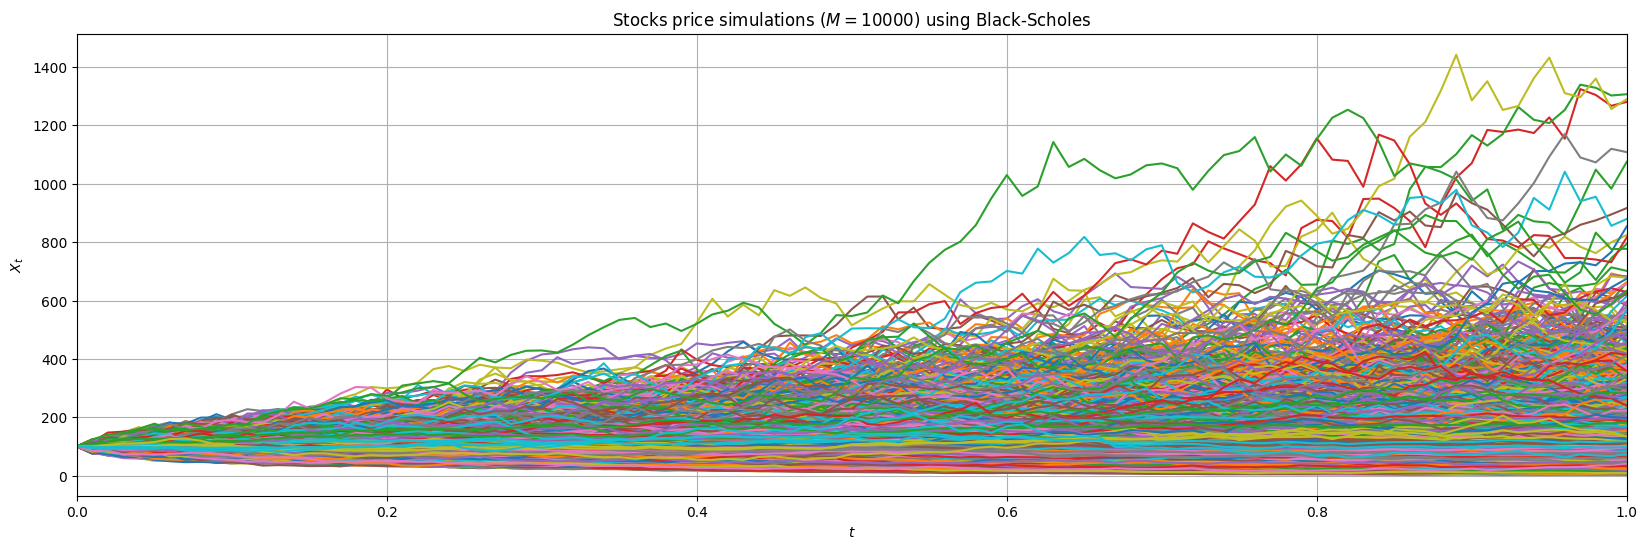

In [11]:
# Simulations output
stocks = stocks_bs(S0, r, sigma, rho, T, N, M)
plot_paths_DD(stocks, T, f"Stocks price simulations ($M = {M}$) using Black-Scholes") # alternatively plot_paths_multi

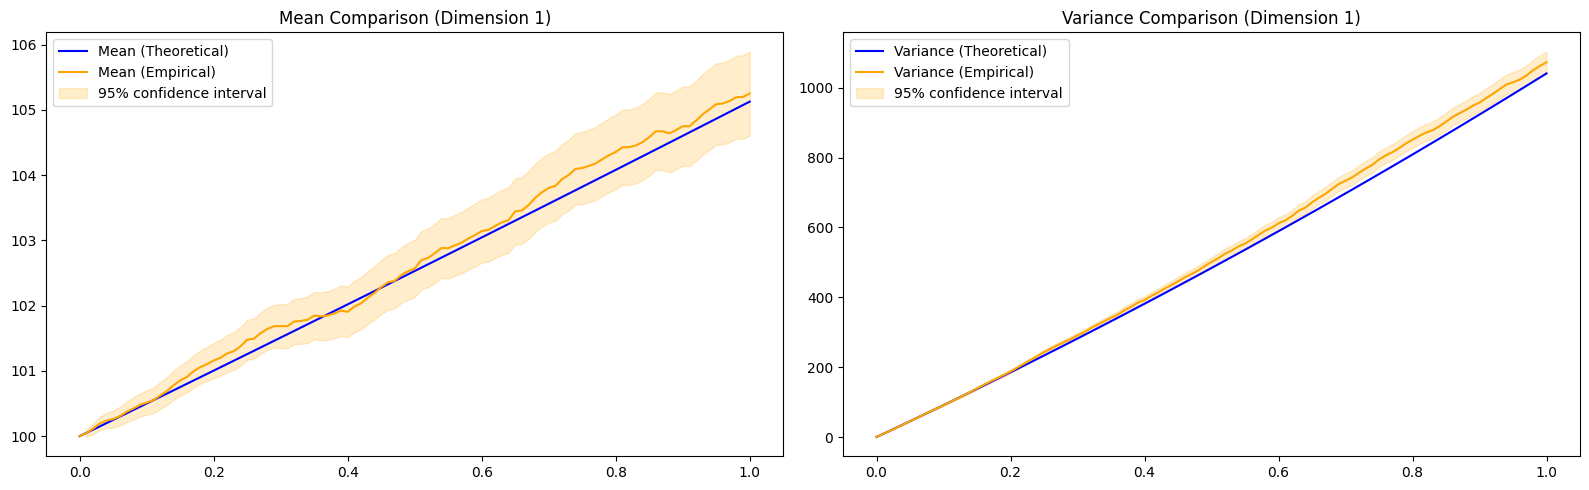

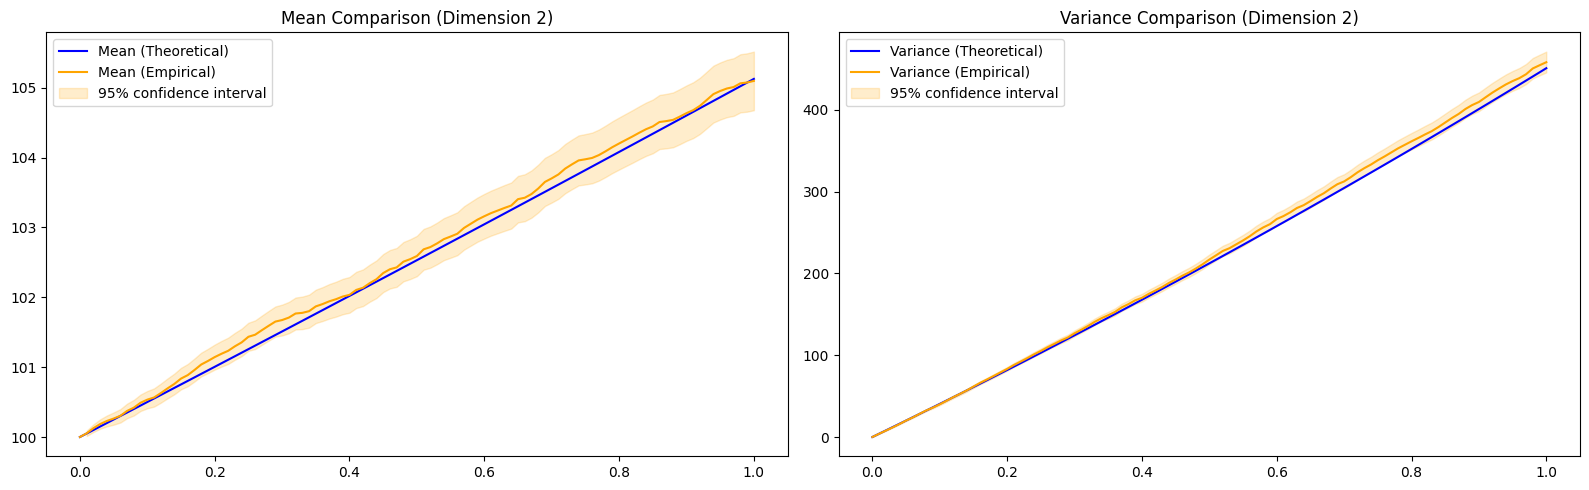

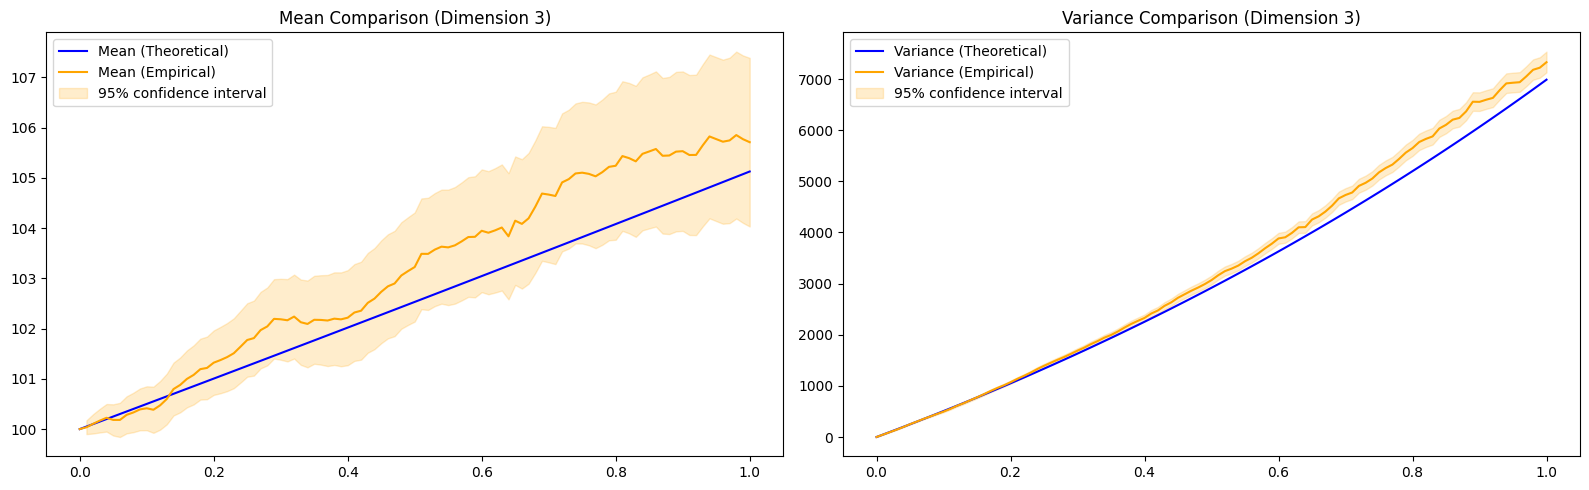

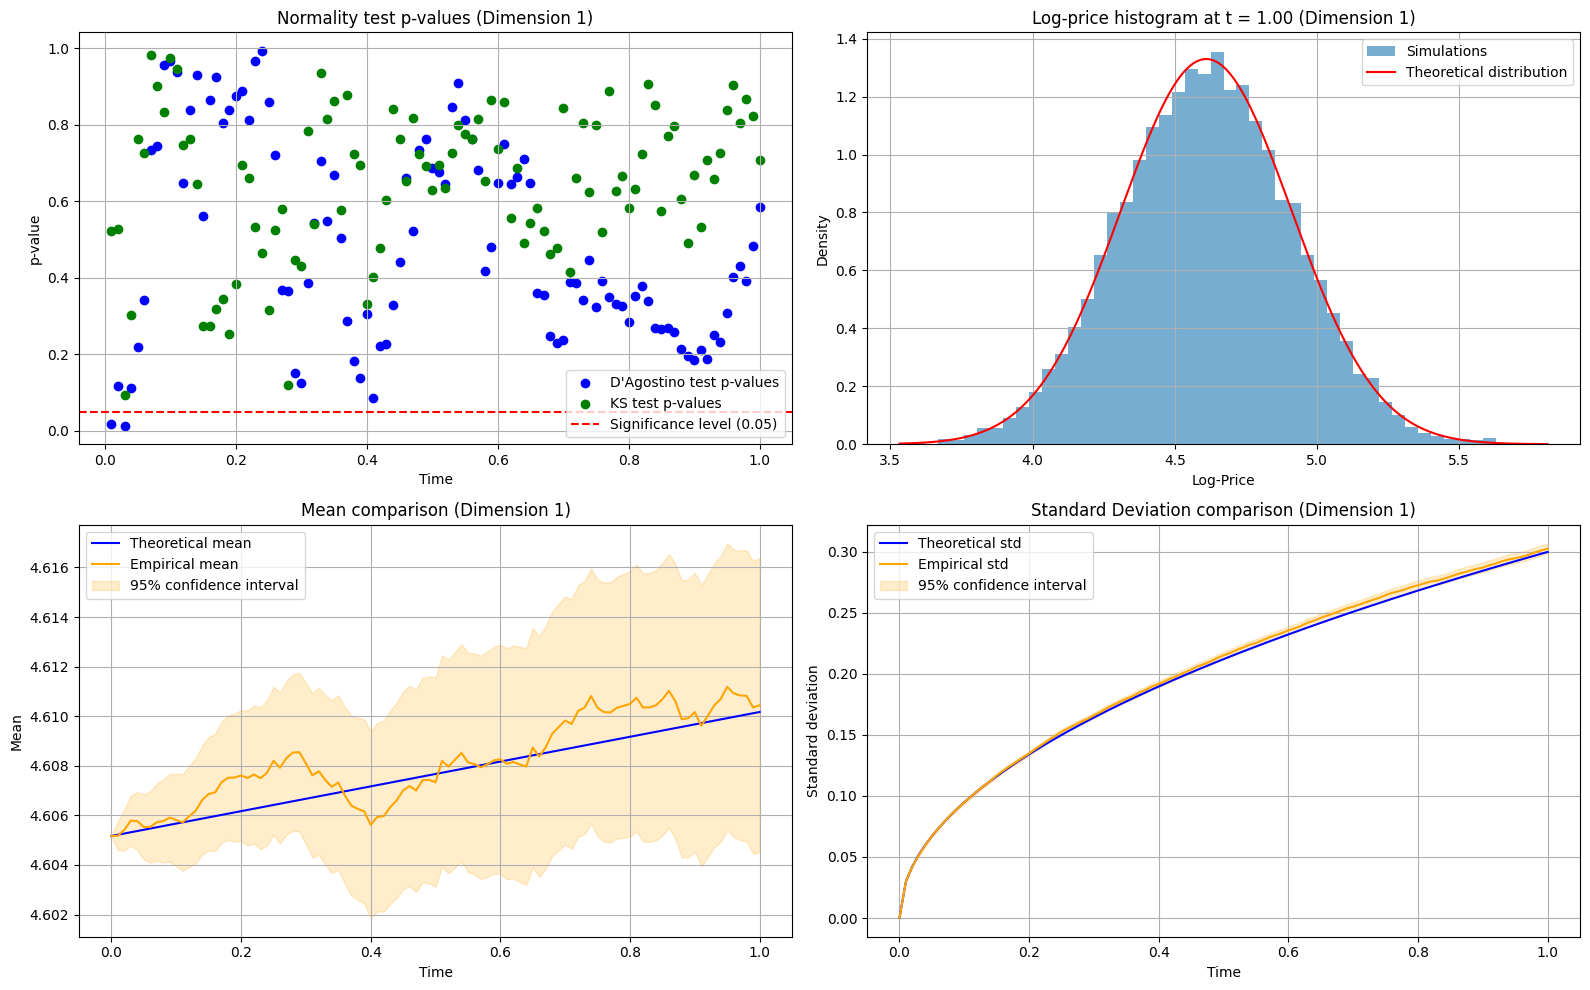

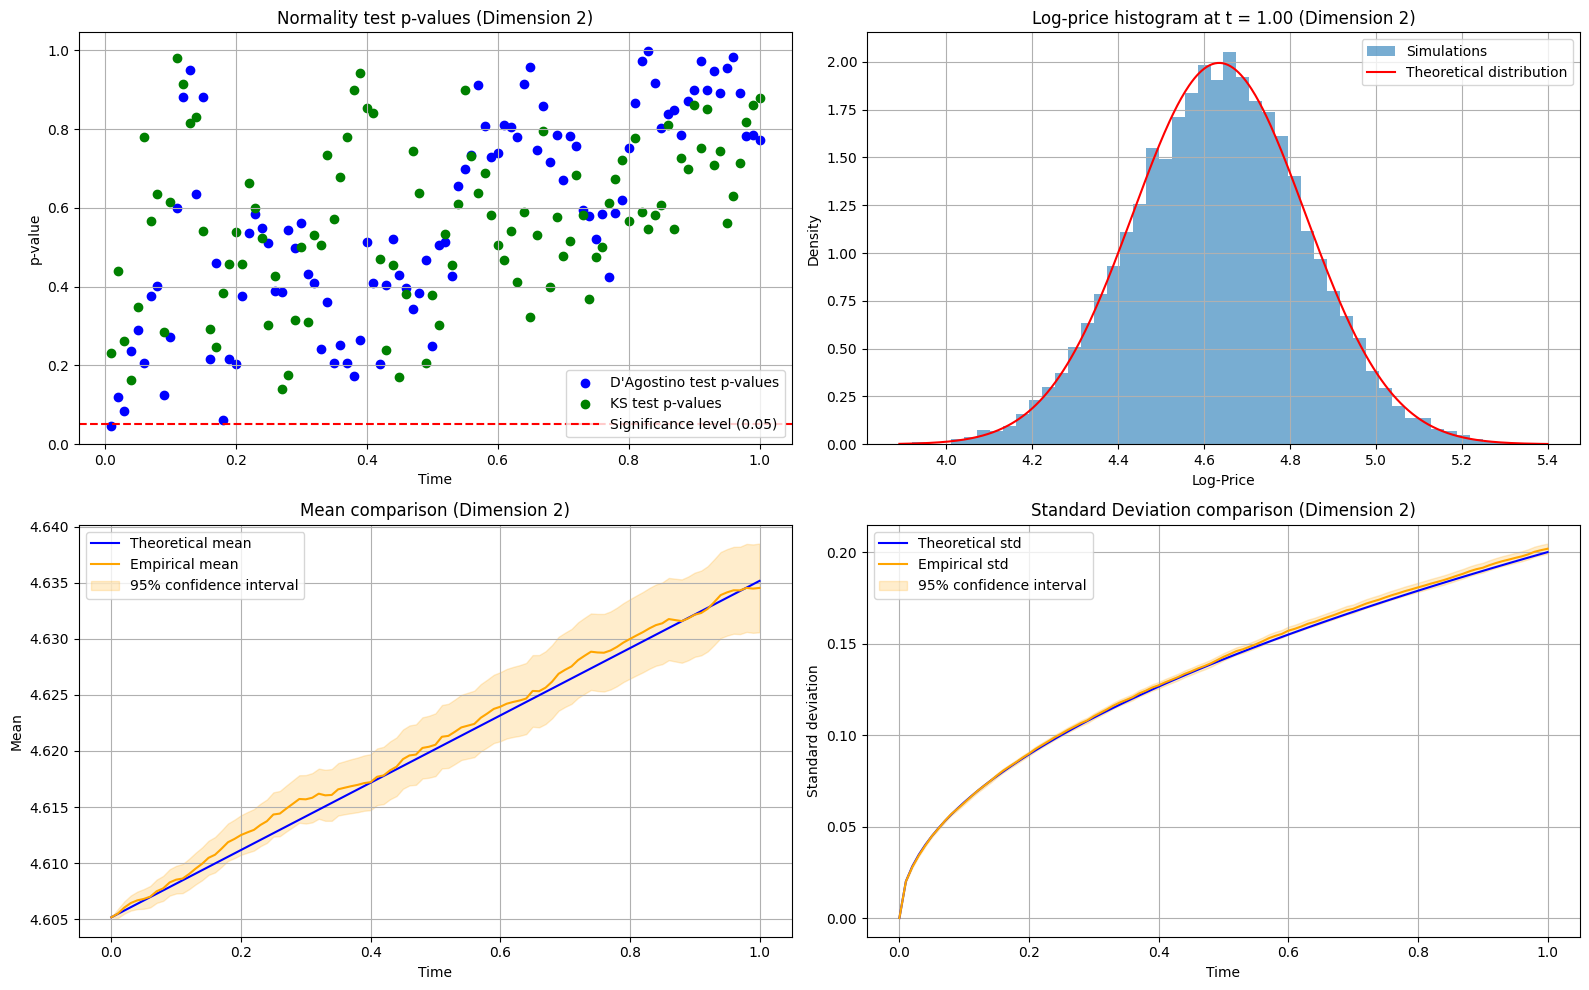

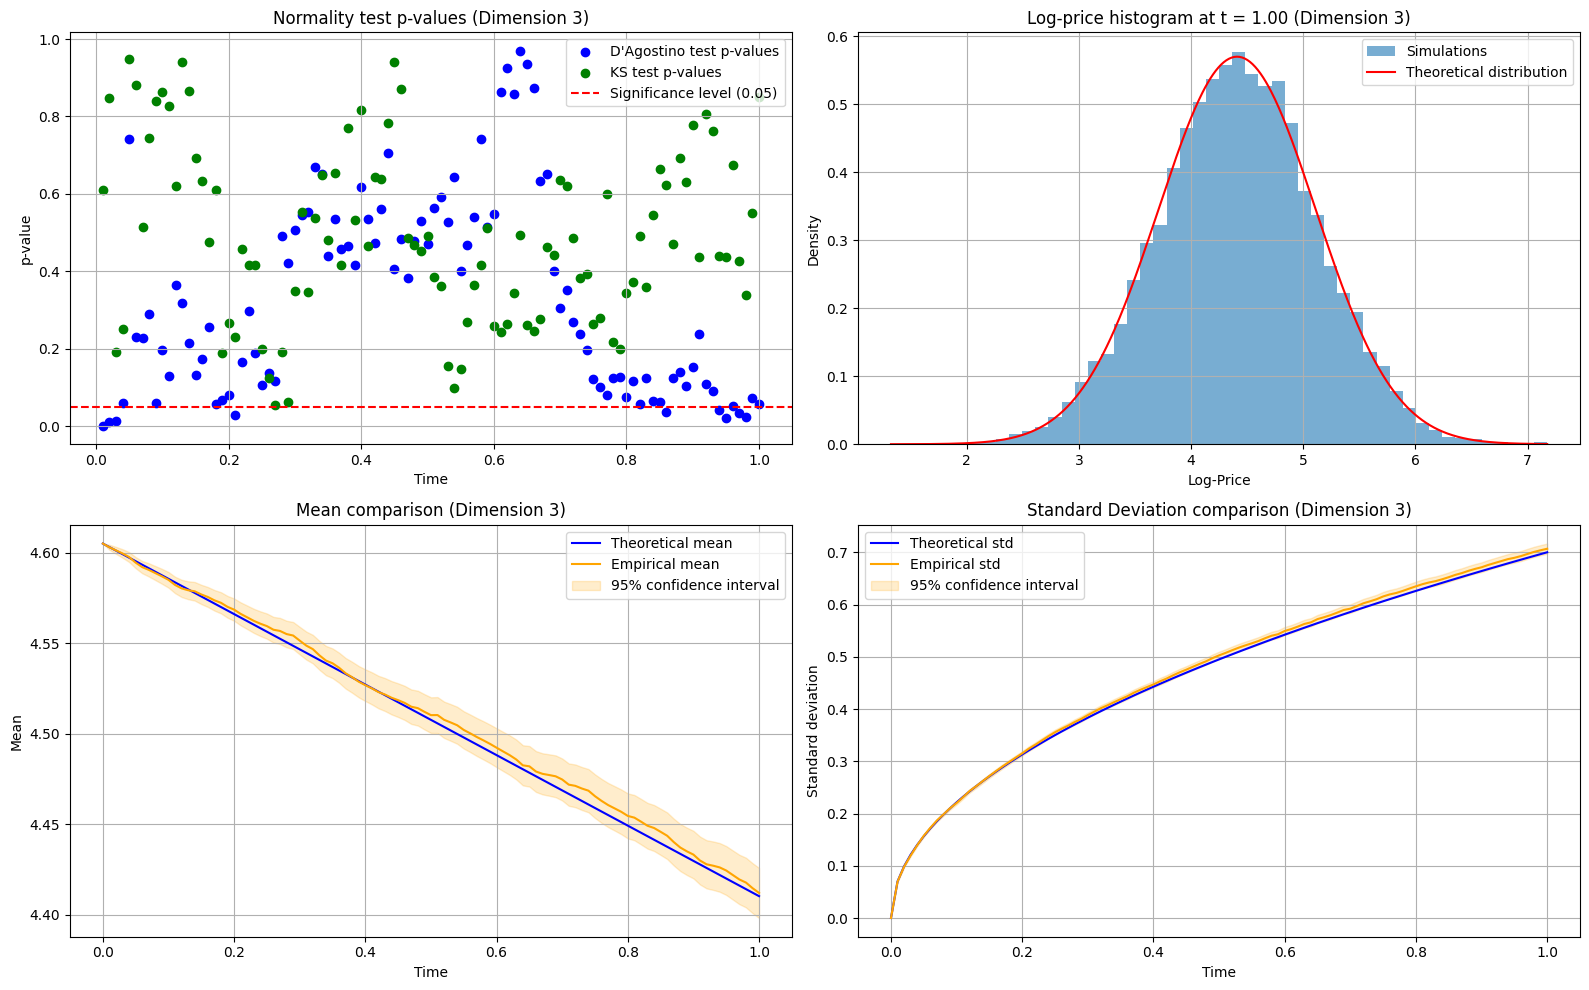

Empirical correlation matrix :
[[1.         0.80001454 0.79984149]
 [0.80001454 1.         0.80011394]
 [0.79984149 0.80011394 1.        ]]


In [12]:
# Verifications
properties_results = check_bs_properties(stocks, S0 = S0, r = r, sigma = sigma, T = T, plots = True)
distribution_results = check_log_normal_distribution(stocks, S0 = S0, r = r, sigma = sigma, T = T, plots = True)
correlation_matrix = check_correlation(stocks)
print("Empirical correlation matrix :")
print(correlation_matrix)

# Longstaff-Schwartz Algorithm
## Some Visualization and Debugging Tools


In [13]:
class LossHistory(tf.keras.callbacks.Callback):
	""" Custom callback to track loss values during training in Keras.
	This callback stores the loss value at the end of each batch and each epoch. It can be used to monitor
	the training process and visualize the loss progression over time.
	Attributes
	----------
	losses_per_epoch : `list`
		List that stores the loss values at the end of each epoch.
	losses_per_batch : `list`
		List that stores the loss values at the end of each batch.
	Methods
	-------
	on_batch_end(batch, logs = None)
		Called at the end of each batch. Saves the loss value for the current batch.
	on_epoch_end(epoch, logs = None)
		Called at the end of each epoch. Saves the loss value for the current epoch.
	"""

	def __init__(self):
		""" Initializes the LossHistory callback, setting up empty lists for losses per epoch and per batch.
		"""
		super().__init__()
		self.losses_per_epoch = []
		self.losses_per_batch = []

	def on_batch_end(self, batch, logs = None):
		""" Saves the loss value after each batch.
		Parameters
		----------
		batch :	`int`
				The index of the batch that has just ended.
		logs : 	`dict`, optional
				A dictionary containing the loss value for the batch (logs['loss']).
		"""
		self.losses_per_batch.append(logs['loss'])

	def on_epoch_end(self, epoch, logs = None):
		""" Saves the loss value after each epoch.
		Parameters
		----------
		epoch :	`int`
				The index of the epoch that has just ended.
		logs :	`dict`, optional
				A dictionary containing the loss value for the epoch (logs['loss']).
		"""
		self.losses_per_epoch.append(logs['loss'])

In [14]:
def plot_continuation(X_train, y_train, y_pred, X_no_train, y_no_train, strike, n):
	""" Plots the predicted continuation values and compares them to the actual data, while also distinguishing favorable and unfavorable
	exercise opportunities. The graphical output also includes Out-of-the-money (OTM) points that were not used for training the model.
    Parameters
    ----------
    X_train :   	`np.ndarray`
                	An array of shape (M, 1) representing the input features at time step n, used for training the model.
    y_train :   	`np.ndarray`
                	An array of shape (M, 1) representing the actual continuation values at time step n+1, corresponding to `X_train`.
    y_pred :    	`np.ndarray`
                	An array of shape (M, 1) representing the continuation values predicted by the model for the input `X_train`.
    X_no_train : 	`np.ndarray`
                 	An array of shape (M_no_train, 1) representing the out-of-the-money (OTM) points not used for training.
    y_no_train :	`np.ndarray`
                 	An array of shape (M_no_train, 1) representing the actual continuation values at time step n+1 for the OTM points.
    strike :    	`float`
                	The strike price `K` of the option.
    n :         	`int`
               		The current time step in the Longstaff-Schwartz algorithm.
    Returns
    -------
    None
        Displays a plot with the actual data points (ITM and OTM) and the model's prediction on ITM paths.
    """
	X_train = X_train.flatten()
	y_train = y_train.flatten()
	y_pred = y_pred.flatten()
	X_no_train = X_no_train.flatten()
	y_no_train = y_no_train.flatten()
	sorted_idx = X_train.argsort()
	above_curve = y_train >= y_pred
	below_curve = ~above_curve
	plt.figure(figsize = (16, 6))
	plt.scatter(X_train[above_curve], y_train[above_curve], color='darkolivegreen', s = 10, alpha=0.8, label='Favorable exercise')
	plt.scatter(X_train[below_curve], y_train[below_curve], color='firebrick', s = 10, alpha=0.8, label='Unfavorable exercise')
	plt.scatter(X_no_train, y_no_train, color = 'lightgrey', s = 10, alpha=0.8, label='OTM points')
	plt.axvline(x = strike, color='steelblue', linestyle='--', linewidth = 1.5, label=f'Srike $K = {strike}$')
	sorted_idx = X_train.flatten().argsort()
	plt.plot(X_train[sorted_idx], y_pred[sorted_idx], color = 'goldenrod', linewidth = 3, label = 'Fitted model: $\Phi(X_{T_n}, \widehat{\\theta}_n^M)$')
	plt.xlabel('Underlying asset price $X_{T_n}$')
	plt.ylabel('Continuation value $\Phi(X_{T_n}, \widehat{\\theta}_n^M)$ / Future payoff $Z_{\\tau_{n+1}}$')
	plt.title("Continuation value approximation $\mathbb{E}[Z_{\\tau_{n+1}} | X_n]$ at step n = " + str(n) + " using ITM points")
	plt.legend()
	plt.grid(True)
	#if n == 9:
	#	plt.savefig("FFNN_approx.png", format = 'png', bbox_inches='tight')
	plt.show()

In [15]:
def plot_loss(loss_history, epochs, n):
	""" Plots the loss per batch and, if applicable, the loss per epoch during the model's learning progress.
	Parameters
	----------
	loss_history :	`LossHistory`
					An instance of the `LossHistory` class that contains the loss values recorded per batch and per epoch during training.
	epochs :		`int`
					The number of epochs the model has been trained for.
	n :				`int`
					The current time step in the Longstaff-Schwartz algorithm, used for the title of the plot.
	Returns
	-------
	None
		Displays two plots showing the loss per batch and, if applicable, the loss per epoch.
	"""
	plt.figure(figsize = (16, 5))
	plt.plot(loss_history.losses_per_batch, label = "Loss per batch", alpha = 0.7)
	plt.xlabel("Batch")
	plt.ylabel("Loss")
	plt.title(f"Loss per batch (n = {n})")
	plt.legend()
	plt.grid()
	plt.show()
	if epochs > 1:
		plt.figure(figsize = (16, 5))
		plt.plot(loss_history.losses_per_epoch, label = "Loss per epoch")
		plt.xlabel("Epochs")
		plt.ylabel("Loss")
		plt.title(f"Loss per epoch (n = {n})")
		plt.legend()
		plt.grid()
		plt.show()

## Algorithm with FFNN and Polynomial Regression


In [16]:
def discounted_payoffs(assets, payoff_fn, r, times, K):
	""" Calculates the discounted payoffs for each simulated asset trajectory.
	Parameters
	----------
	assets :	`np.ndarray` of shape (M, d, N+1)
				Simulated asset trajectories where M is the number of simulations, d is the number of dimensions, and N is the number of time steps.
	payoff_fn :	`function`
				A function that computes the payoff for a given asset value. The function should take the asset value at a given time and the strike price (K) as input.
	r : 		`float`
				Risk-free interest rate, used to discount the payoff.
	times : 	`np.array`
				Discretized valuation times.
	K : 		`float`
				Strike price used in the payoff function.
	Returns
	-------
	discounted_payoffs :	`np.ndarray` of shape (M, N+1)
							An array of discounted payoffs where each element corresponds to the discounted payoff for a given trajectory and time.
	"""
	M, d, N = assets.shape
	N -= 1
	discount_factors = np.exp(-r * times)
	reshaped_assets = assets.transpose(0, 2, 1).reshape(-1, d)
	payoff_partial = partial(payoff_fn, K=K)
	payoff_partial_vectorized = np.vectorize(payoff_partial, signature="(d)->()")
	reshaped_payoffs = payoff_partial_vectorized(reshaped_assets)
	payoffs = reshaped_payoffs.reshape(M, N + 1)
	discounted_payoffs = payoffs * discount_factors[np.newaxis, :]
	discounted_payoffs = np.squeeze(discounted_payoffs)
	return discounted_payoffs

In [17]:
class Option:
	""" Represents an option with various parameters such as spot price, risk-free rate, volatility, and more.
	This class encapsulates the parameters necessary for defining an option, including its payoff function, type, and dimensions.
	Parameters
	----------
	S0 :			`float`
					Initial (current) spot price of the underlying asset. If `d > 1`, it will be replicated across all dimensions.
	r :				`float`
					Risk-free interest rate.
	sigma :			`float`
					Volatility of the underlying asset. Can be replicated across all dimensions if `d > 1`.
	T :				`float`
					Time to maturity of the option.
	K :				`float`
					Strike price of the option.
	N :				`int`
					Number of exercise dates.
	M :				`int`
					Number of simulations to perform.
	payoff_fn :		`function`
					The function used to calculate the payoff of the option.
	rho :			`float`, optional
					Correlation factor between the dimensions, used only if `d > 1`. Default is 0.
	div :			`float`, optional
					Dividend rate of the underlying asset. Default is 0.
	option_type :	`str`, optional
					The type of the option, e.g., "Call" or "Put". Default is "Option".
	d :				`int`, optional
					Number of dimensions for the underlying asset. Default is 1 (unidimensional).
	Attributes
	----------
	S0 :			`float` or `np.ndarray`
					The spot price, replicated across all dimensions if necessary.
	r :				`float`
					The risk-free rate.
	div :			`float`
					The dividend rate.
	sigma :			`float` or `np.ndarray`
					The volatility, replicated across all dimensions if necessary.
	rho :			`float`
					The correlation factor (only used if `d > 1`).
	T :				`float`
					The time to maturity.
	K :				`float`
					The strike price.
	N :				`int`
					The number of exercise dates.
	M :				`int`
					The number of simulations.
	payoff_fn :		`function`
					The payoff function for the option.
	option_type :	`str`
					The type of the option.
	d :				`int`
					The number of dimensions.
	Returns
	-------
	None
		Initializes the option with the given parameters.
	"""
	def __init__(self, S0, r, sigma, T, K, N, M, payoff_fn, rho = 0., div = 0., option_type = None, d = 1):
		self.S0 = float(S0)  if d == 1 else np.full(d, S0) # Spot price
		self.r = r    # Risk-free rate
		self.div = div	# Dividend rate
		self.sigma = sigma  if d == 1 else np.full(d, sigma) # Volatility
		self.rho = rho	if d > 1 else 0 # Correlation factor
		self.T = T    # Time to maturity
		self.K = K    # Strike price
		self.N = N	# Number of exercise dates
		self.M = M	# Number of simulations
		self.payoff_fn = payoff_fn  # Payoff function
		self.option_type = option_type if option_type else "Option" # Option type
		self.d = d	# Dimensions

	def __repr__(self):
		info = f"{self.option_type} (d = {self.d}): S0 = {self.S0}, r = {self.r}, " if self.d == 1 else f"{self.option_type} (d = {self.d}): S0 = {self.S0[0]}, r = {self.r}, "
		info += f"delta = {self.div}, " if self.div != 0 else ""
		info += f"sigma = {self.sigma}, T = {self.T}, K = {self.K}, N = {self.N}, M = {self.M}" if self.d == 1 else f"sigma = {self.sigma[0]}, rho = {self.rho}, T = {self.T}, K = {self.K}, N = {self.N}, M = {self.M}"
		return info

	def __str__(self):
		return self.__repr__()

In [18]:
def build_ffnn(input_dim, layers = 2, neurons = 32):
	""" Builds a feedforward neural network (FFNN) with a specified number of layers and neurons per layer,
	with Leaky ReLU activation functions and Adam optimizer.
	Parameters
	----------
	input_dim :	`int`
				Dimensionality of the input data (number of features).
	layers :	`int`, optional
				Number of layers in the neural network. Default is 2.
	neurons :	`int`, optional
				Number of neurons in each hidden layer. Default is 32.
	Returns
	-------
	model :		`tf.keras.Model`
				A compiled feedforward neural network model with the specified architecture.
	"""
	model = Sequential()
	model.add(Input(shape=(input_dim,)))
	model.add(Dense(neurons, kernel_initializer=HeUniform()))
	model.add(LeakyReLU(negative_slope=0.3))
	for _ in range(layers - 2):
		model.add(Dense(neurons, kernel_initializer=HeUniform()))
		model.add(LeakyReLU(negative_slope = 0.3))
	model.add(Dense(1, activation = None, kernel_initializer=HeUniform()))
	model.compile(optimizer = 'adam', loss = 'mse')
	return model

In [19]:
def longstaff_schwartz(assets, payoffs, option, mode, order = 1, layers = 2, neurons = 32, epochs = 1, print_loss = False, print_cont = False):
	""" Performs the Longstaff-Schwartz algorithm for pricing Bermudan options using a feedforward neural network (FFNN) or polynomial regressions.
	The method iteratively approximates the continuation value using a neural network trained at each time step.
	Parameters
	----------
	assets :		`np.array` of size (2 * M, d, N + 1)
					Underlying asset price simulations of dimension d for 2 * M trajectories valued at N+1 time steps.
	payoffs :		`np.array` of size (2 * M, N + 1)
					Immediate discounted payoff valued at N + 1 time steps for the M trajectories.
	option :		`Option`
					An instance of the `Option` class, containing the parameters for the option (e.g., initial price, volatility, etc.).
	mode:			`str`
					Method to approximate the continuation values, either "ffnn" or "polyreg"
	order:			`int`
					Order of the polynomial regression. Default is 1.
	layers :		`int`, optional
					Number of layers in the FFNN. Default is 2.
	neurons :		`int`, optional
					Number of neurons in each hidden layer. Default is 32.
	epochs :		`int`, optional
					Number of epochs to train the neural network. Default is 1.
	print_loss :	`bool`, optional
					Whether to plot the loss per batch and per epoch during training. Default is False.
	print_cont :	`bool`, optional
					Whether to plot the continuation values during the algorithm. Default is False.
	Returns
	-------
	price :			`float`
					The estimated price of the Bermudan option, based on the Longstaff-Schwartz method with the FFNN model.
	"""
	if mode != "ffnn" and mode != "polyreg":
		raise ValueError("mode must be either 'ffnn' or 'polyreg'")
	N = assets.shape[2] - 1
	M = assets.shape[0]
	# LS algorithm initialisation
	input_dim = assets.shape[1]
	if mode == "ffnn":
		model = build_ffnn(input_dim, layers = layers, neurons = neurons)
		scaler = StandardScaler()
		M = int(M / 2) # split sample into training and application sets
		tau_train = np.full((M), N)
	tau_app = np.full((M), N)
	# Dynamic programming principle
	for n in range(N-1, 0, -1):
		# Data selection for application set
		X_app = assets[:M, :, n]
		y_app = payoffs[np.arange(M), tau_app]
		itm_app = payoffs[:M, n] > 0
		X_app_filtered = X_app[itm_app]
		y_app_filtered = y_app[itm_app, np.newaxis]
		# Train model and compute continuation values
		if mode == "ffnn":
			loss_history = LossHistory() # Callback initialisation
			callbacks = [loss_history] if print_loss else None
			# Data selection for training set
			X_train = assets[-M:, :, n]
			y_train = payoffs[np.arange(M, M * 2), tau_train]
			itm_train = payoffs[-M:, n] > 0
			X_train_filtered = X_train[itm_train]
			y_train_filtered = y_train[itm_train, np.newaxis]
			# Train model
			if n == N-1:
				X_train_normalized = scaler.fit_transform(X_train_filtered)
			else:
				epochs = 1
				X_train_normalized = scaler.transform(X_train_filtered)
			model.fit(X_train_normalized, y_train_filtered, epochs = epochs, batch_size = 32, callbacks = callbacks, verbose = 0)
			if print_loss:
				plot_loss(loss_history, epochs, n)
			del loss_history, callbacks
			# Continuation values
			X_app_normalized = scaler.transform(X_app_filtered)
			continuation_train = model.predict(X_train_normalized, batch_size = min(1024, len(X_train_normalized)), verbose = 0)
			continuation_app = model.predict(X_app_normalized, batch_size = min(1024, len(X_app_normalized)), verbose = 0)
			# Update optimal stopping times for training set
			itm_payoffs_train = payoffs[-M:, n][itm_train]
			condition_train = itm_payoffs_train >= continuation_train[:, 0]
			tau_train[itm_train] = np.where(condition_train, n, tau_train[itm_train])
		else:
			model = make_pipeline(PolynomialFeatures(order), LinearRegression())
			model.fit(X_app_filtered, y_app_filtered)
			continuation_app = model.predict(X_app_filtered)
		if print_cont and X_train_filtered.shape[1] < 2:
			plot_continuation(X_app_filtered, y_app_filtered, continuation_app, X_app[~itm_app], y_app[~itm_app, np.newaxis], option.K, n)
		# Update optimal stopping times for application set
		itm_payoffs_app = payoffs[:M, n][itm_app]
		condition_app = itm_payoffs_app >= continuation_app[:, 0]
		tau_app[itm_app] = np.where(condition_app, n, tau_app[itm_app])
	# Monte Carlo of optimal payoffs
	optimal_payoffs = payoffs[np.arange(M), tau_app]
	MC = np.mean(optimal_payoffs)
	price = max(payoffs[0, 0], MC)
	tf.keras.backend.clear_session()
	gc.collect()
	return price

## Option Price Simulations
The following function allows you to simulate `n_sim` option price paths in order to compute the mean and the 95% confidence interval.


In [20]:
def price_estimator(option, mode, orders = [1, 2, 3], layers = 2, neurons = 32, epochs = [1, 5, 10], n_sim = 100, print_cont = False):
	""" Estimates the price of an option by running multiple simulations using the Longstaff-Schwartz method.
	The function runs a specified number of simulations (up to 3 attempts) and returns the average price, confidence interval, and simulation details.
	Parameters
	----------
	option :		`Option`
					An instance of the `Option` class, containing the parameters for the option (e.g., initial price, volatility, etc.).
	mode:			`str`
					Method to approximate the continuation values, either "ffnn" or "polyreg"
	orders:			`list` of `int`, optional
					Orders of the polynomial regression. Default is [1, 2, 3].
	layers :		`int`, optional
					Number of layers in the FFNN. Default is 2.
	neurons :		`int`, optional
					Number of neurons in each hidden layer. Default is 32.
	epochs :		`list` of `int`, optional
					Numbers of epochs to train the neural network. Default is [1, 5, 10].
	n_sim :			`int`, optional
					Number of simulations to run. Default is 100.
	Returns
	-------
	params :		`list` of `int`
					List of the number of epochs or order used in each simulation.
	mean_price :	`list` of `float` or `None`
					The mean price obtained from the simulations, or `np.nan` if no valid simulations were successful.
	ci_half_width :	`list` of `float` or `None`
					The half-width of the 95% confidence interval for the estimated price, or `np.nan` if no valid simulations were successful.
	prices :		`list` of `list` of `float`
					List of the prices obtained from each simulation for each parameter in params.
	error_log :		`list` of `list` of `str`
					Log of error messages for any failed simulations, including details on the error and attempts for each parameter in params.
	"""
	if mode == "ffnn":
		params = epochs
	elif mode == "polyreg":
		params = orders
	else:
		raise ValueError("mode must be either 'ffnn' or 'polyreg'")
	prices = np.full((len(params), n_sim), np.nan)
	error_log = [[] for _ in range(len(params))]
	n_sample = option.M if mode == "polyreg" else option.M * 2
	for i in tqdm(range(n_sim), desc = "Price simulations", leave = False):
		np.random.seed(i)
		tf.random.set_seed(i)
		# Simulate trajectories valued 100 times per year for more precision
		N_sim = option.T * 100
		assets_full = stocks_bs(option.S0, option.r - option.div, option.sigma, option.rho, option.T, N_sim, n_sample)
		# Retrieve times and values of interest (exercices dates)
		times = np.linspace(0, option.T, option.N + 1)
		indices = np.round(times / option.T * N_sim).astype(int)
		assets = assets_full[:, :, indices]
		del assets_full
		times_full = np.linspace(0, option.T, N_sim + 1)
		times = times_full[indices]
		del times_full
		# Compute immediate payoffs at exercise dates
		payoffs = discounted_payoffs(assets, option.payoff_fn, option.r, times, option.K)
		# Compute price with various params using Longstaff-Schwartz
		for j, param in enumerate(params):
			for attempt in range(3):
				try:
					price = longstaff_schwartz(assets, payoffs, option, mode, order = param, layers = layers, neurons = neurons, epochs = param, print_cont = print_cont)
					prices[j, i] = price
					break
				except Exception as e:
					error_message = f"Simulation {i+1}, Attempt {attempt+1}: {str(e)}"
					error_log[j].append(error_message)
	# Compute mean price and ci over simulated prices
	mean_prices = np.nanmean(prices, axis=1)
	std_devs = np.nanstd(prices, axis=1, ddof=1)
	sim_success = np.count_nonzero(~np.isnan(prices), axis=1)
	valid_mask = sim_success > 1
	t_values = np.full_like(sim_success, np.nan, dtype=np.float64)
	t_values[valid_mask] = stats.t.ppf(0.975, df=sim_success[valid_mask] - 1)
	ci_half_width = np.where(valid_mask, t_values * std_devs / np.sqrt(sim_success), np.nan)
	# Error warnings
	for j, n in enumerate(sim_success):
		if n < n_sim and mode == "ffnn":
			print(f"Simulation error(s) for epochs = {epochs[j]}: calculating results with the obtained data.")
		elif n < n_sim and mode == "polyreg":
			print(f"Simulation error(s) for order = {orders[j]}: calculating results with the obtained data.")
	return params, mean_prices, ci_half_width, prices, error_log


Another version of this function using `joblib` to parallelize the computations and speed up the execution of the simulations:


In [21]:
def price_estimator_parallel(option, mode, orders = [1, 3, 6], layers = 2, neurons = 32, epochs = [1, 5, 10], n_sim = 100):
	""" Estimates the price of an option by running multiple simulations using the Longstaff-Schwartz method.
	The function runs a specified number of simulations (up to 3 attempts) and returns the average price, confidence interval, and simulation details.
	Utilizes all available CPU cores to speed up the simulations using joblib module.
	Parameters
	----------
	option :		`Option`
					An instance of the `Option` class, containing the parameters for the option (e.g., initial price, volatility, etc.).
	mode:			`str`
					Method to approximate the continuation values, either "ffnn" or "polyreg"
	orders:			`list` of `int`, optional
					Orders of the polynomial regression. Default is [1, 2, 3].
	layers :		`int`, optional
					Number of layers in the FFNN. Default is 2.
	neurons :		`int`, optional
					Number of neurons in each hidden layer. Default is 32.
	epochs :		`list` of `int`, optional
					Numbers of epochs to train the neural network. Default is [1, 5, 10].
	n_sim :			`int`, optional
					Number of simulations to run. Default is 100.
	Returns
	-------
	params :		`list` of `int`
					List of the number of epochs or order used in each simulation.
	mean_price :	`list` of `float` or `None`
					The mean price obtained from the simulations, or `np.nan` if no valid simulations were successful.
	ci_half_width :	`list` of `float` or `None`
					The half-width of the 95% confidence interval for the estimated price, or `np.nan` if no valid simulations were successful.
	prices :		`list` of `list` of `float`
					List of the prices obtained from each simulation for each parameter in params.
	error_log :		`list` of `list` of `str`
					Log of error messages for any failed simulations, including details on the error and attempts for each parameter in params.
	"""
	if mode == "ffnn":
		params = epochs
	elif mode == "polyreg":
		params = orders
	else:
		raise ValueError("mode must be either 'ffnn' or 'polyreg'")
	n_sample = option.M if mode == "polyreg" else option.M * 2
	
	# Helper function to generate trajectories and compute prices for all epochs
	def process_simulation(sim_id):
		np.random.seed(sim_id)  # Fix seed for reproducibility
		tf.random.set_seed(sim_id)
		N_sim = option.T * 100
		# Simulate trajectories valued 100 times per year for more precision
		assets_full = stocks_bs(option.S0, option.r - option.div, option.sigma, option.rho, option.T, N_sim, n_sample)
		# Retrieve times and values of interest (exercise dates)
		times = np.linspace(0, option.T, option.N + 1)
		indices = np.round(times / option.T * N_sim).astype(int)
		assets = assets_full[:, :, indices]
		del assets_full
		times_full = np.linspace(0, option.T, N_sim + 1)
		times = times_full[indices]
		del times_full
		# Compute immediate payoffs at exercise dates
		payoffs = discounted_payoffs(assets, option.payoff_fn, option.r, times, option.K)
		# Compute price with various params using Longstaff-Schwartz
		prices = np.full((len(params)), np.nan)
		error_log = [[] for _ in range(len(params))]
		for i, param in enumerate(params):
			for attempt in range(3):
				try:
					price = longstaff_schwartz(assets, payoffs, option, mode, order = param, layers = layers, neurons = neurons, epochs = param)
					prices[i] = price
					break
				except Exception as e:
					error_message = f"Simulation {sim_id+1}, Attempt {attempt+1} : {str(e)}"
					error_log[i].append(error_message)
		return prices, error_log

	# Run simulations in parallel
	with tqdm_joblib(tqdm(desc="Price simulations", total=n_sim, leave=False, dynamic_ncols= True), dynamic_ncols=True, leave = False) as progress_bar:
		results = Parallel(n_jobs=-1)(delayed(process_simulation)(i) for i in range(n_sim))
	# Unpack results
	prices = np.array([result[0] for result in results]).T
	error_log = [[] for _ in range(len(params))]
	for i, param in enumerate(params):
		error_log[i] = [error_message for result in results for error_message in result[1][i]]
	# Compute mean price and ci over simulated prices
	mean_prices = np.nanmean(prices, axis=1)
	std_devs = np.nanstd(prices, axis=1, ddof=1)
	sim_success = np.count_nonzero(~np.isnan(prices), axis=1)
	valid_mask = sim_success > 1
	t_values = np.full_like(sim_success, np.nan, dtype=np.float64)
	t_values[valid_mask] = stats.t.ppf(0.975, df=sim_success[valid_mask] - 1)
	ci_half_width = np.where(valid_mask, t_values * std_devs / np.sqrt(sim_success), np.nan)
	# Error warnings
	for j, n in enumerate(sim_success):
		if n < n_sim and mode == "ffnn":
			print(f"Simulation error(s) for epochs = {epochs[j]}: calculating results with the obtained data.")
		elif n < n_sim and mode == "polyreg":
			print(f"Simulation error(s) for order = {orders[j]}: calculating results with the obtained data.")
	return params, mean_prices, ci_half_width, prices, error_log

# Numerical Examples


### Put Option (1 dimension)


In [22]:
def put_payoff(St, K):
	""" Computes payoff of a Put option.
	Parameters
	----------
	St:	`float`
		Stock price.
	K:	`float`
		Strike price.
	Returns
	-------
	P:	`float`
		Put payoff.
	"""
	P = max(K - St, 0)
	return P

##### Example: $d = 1$, $r = 0.1$, $\sigma = 0.25$, $T = 1$, $K = 110$, $S_0 = 100$, $N = 10$, $M = 100000$ (Reference price = 11.987)


In [52]:
option = Option(d = 1, S0 = 100, r = 0.1, sigma = 0.25, T = 1, K = 110, N = 10, M = 100000, payoff_fn = put_payoff, option_type = "Put Option")

In [24]:
orders = [1, 3, 6]
print(option)
print("Polynomial regression with orders", ', '.join(map(str, orders)))
orders, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "polyreg", orders = orders) # alternatively price_estimator
for i, order in enumerate(orders):
	print(f"order = {order} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Put Option (d = 1): S0 = 100.0, r = 0.1, sigma = 0.25, T = 1, K = 110, N = 10, M = 100000
Polynomial regression with orders 1, 3, 6


Price simulations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

order = 1 : P = 11.859823711479018 (± 0.006376590718117278)
order = 3 : P = 11.98437740147548 (± 0.006321582696507076)
order = 6 : P = 11.98564894343365 (± 0.0063106204368456684)


In [25]:
L, dl = 2, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Put Option (d = 1): S0 = 100.0, r = 0.1, sigma = 0.25, T = 1, K = 110, N = 10, M = 100000
FFNN with L = 2 layers of dl = 32 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/celinenguyen/Documents/M2 IFMA/Méthodes avancées en probabilités numériques/Projet/BermudeanOption/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2025-02-16 18:55:34.962640: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [32] vs. [0]
	 [[{{function_node __inference_one_step_on_data_67712}}{{node adam/Mul_7}}]]


epochs = 1 : P = 11.968540331605507 (± 0.006358891962934804)
epochs = 5 : P = 11.971252965349695 (± 0.006170510456522506)
epochs = 10 : P = 11.972758611471008 (± 0.006289741734259934)


In [26]:
L, dl = 2, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Put Option (d = 1): S0 = 100.0, r = 0.1, sigma = 0.25, T = 1, K = 110, N = 10, M = 100000
FFNN with L = 2 layers of dl = 128 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

2025-02-16 19:36:53.008143: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input to reshape is a tensor with 1 values, but the requested shape has 32
	 [[{{function_node __inference_one_step_on_data_4979930}}{{node gradient_tape/compile_loss/mse/sub/Reshape}}]]


epochs = 1 : P = 11.959739211033332 (± 0.006631246229954428)
epochs = 5 : P = 11.966688375463654 (± 0.006592970205650396)
epochs = 10 : P = 11.968328271470217 (± 0.006584023822451973)


In [27]:
L, dl = 2, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Put Option (d = 1): S0 = 100.0, r = 0.1, sigma = 0.25, T = 1, K = 110, N = 10, M = 100000
FFNN with L = 2 layers of dl = 512 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

2025-02-16 19:45:39.126634: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [512,1] using a Tensor with shape [512,0], shapes must be equal.
2025-02-16 19:45:39.126669: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot update variable with shape [512,1] using a Tensor with shape [512,0], shapes must be equal.
	 [[{{function_node __inference_one_step_on_data_423605}}{{node adam/AssignSubVariableOp_2}}]]


epochs = 1 : P = 11.942009799347579 (± 0.008174321674596457)
epochs = 5 : P = 11.946467477526513 (± 0.0076830061811075144)
epochs = 10 : P = 11.948377183161638 (± 0.007414368348502344)


In [28]:
L, dl = 4, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Put Option (d = 1): S0 = 100.0, r = 0.1, sigma = 0.25, T = 1, K = 110, N = 10, M = 100000
FFNN with L = 4 layers of dl = 32 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

                                                          


2025-02-16 20:32:56.308494: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0] vs. [32,32]
	 [[{{function_node __inference_one_step_on_data_157122}}{{node adam/truediv_5}}]]


epochs = 1 : P = 11.92025993173463 (± 0.009932803460016838)
epochs = 5 : P = 11.929173422173852 (± 0.009974879939635636)
epochs = 10 : P = 11.93406038304692 (± 0.009522023266757662)


In [29]:
L, dl = 4, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Put Option (d = 1): S0 = 100.0, r = 0.1, sigma = 0.25, T = 1, K = 110, N = 10, M = 100000
FFNN with L = 4 layers of dl = 128 neurons


Price simulations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 11.88499390922274 (± 0.012187980075560498)
epochs = 5 : P = 11.903887825610823 (± 0.011225319984251091)
epochs = 10 : P = 11.915970134837902 (± 0.01026903578649874)


In [30]:
L, dl = 4, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Put Option (d = 1): S0 = 100.0, r = 0.1, sigma = 0.25, T = 1, K = 110, N = 10, M = 100000
FFNN with L = 4 layers of dl = 512 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 11.846995923489185 (± 0.016212817812041796)
epochs = 5 : P = 11.876503206838343 (± 0.014621056242807304)
epochs = 10 : P = 11.891667007724289 (± 0.013158957076710429)


In [31]:
L, dl = 8, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Put Option (d = 1): S0 = 100.0, r = 0.1, sigma = 0.25, T = 1, K = 110, N = 10, M = 100000
FFNN with L = 8 layers of dl = 32 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

2025-02-17 02:11:13.525091: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0] vs. [32,32]
	 [[{{function_node __inference_one_step_on_data_619530}}{{node adam/truediv_5}}]]


epochs = 1 : P = 11.886039287725621 (± 0.012938427519376267)
epochs = 5 : P = 11.90908433620541 (± 0.011457900603692235)
epochs = 10 : P = 11.917159626695367 (± 0.010938129944231986)


In [32]:
L, dl = 8, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Put Option (d = 1): S0 = 100.0, r = 0.1, sigma = 0.25, T = 1, K = 110, N = 10, M = 100000
FFNN with L = 8 layers of dl = 128 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 11.868081602327013 (± 0.014068448371462327)
epochs = 5 : P = 11.896177097361974 (± 0.011890840719744977)
epochs = 10 : P = 11.907828941137128 (± 0.010320197781922783)


In [53]:
L, dl = 8, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Put Option (d = 1): S0 = 100.0, r = 0.1, sigma = 0.25, T = 1, K = 110, N = 10, M = 100000
FFNN with L = 8 layers of dl = 512 neurons


                                                          2025-02-22 15:48:09.488361: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [512,512] vs. [0]
	 [[{{function_node __inference_one_step_on_data_281922621}}{{node adam/Mul_43}}]]


epochs = 1 : P = 11.643230778644638 (± 0.06408194366391282)
epochs = 5 : P = 11.664130145520945 (± 0.05582482974213791)
epochs = 10 : P = 11.67587836805324 (± 0.0627950770860294)


### Geometric Basket Put Option


In [23]:
def geom_basket_put_payoff(St, K):
	""" Computes the payoff of a geometric basket Put option.
	Parameters
	----------
	St:	`np.ndarray`
		Array of stock prices.
	K:	`float`
		Strike price of the option.
	Returns
	-------
	P:	`float`
		Payoff of the geometric basket Put option, calculated as max(K - (geometric mean of St), 0).
	"""
	product = np.prod(St)
	d = St.size
	P = max(K - product ** (1/d), 0)
	return P

In [23]:
def to_1D_geom_basket_option(option):
	Gamma = np.full((option.d, option.d), option.rho)
	np.fill_diagonal(Gamma, 1)
	sigma = (1/option.d) * np.sqrt(np.dot(option.sigma.T, np.dot(Gamma, option.sigma)))
	div = np.full(option.d, option.div)
	delta = np.mean(div + 0.5 * (option.sigma ** 2)) - 0.5 * sigma **2
	option_1D = Option(option.S0[0], option.r, sigma, option.T, option.K, option.N, option.M, option.payoff_fn, 0, delta, option.option_type, 1)
	return option_1D

##### Example 1: $d = 2$, $r = 0.05$, $\sigma^i = 0.2$, $\delta^i = 0$, $\rho = 0.2$, $T = 1$, $K = 100$, $S_0^i = 100$, $N = 10$, $M = 100000$ (Reference price = 4.57)


In [24]:
option = Option(d = 2, S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, div = 0, T = 1, K = 100, N = 10, M = 100000, payoff_fn = geom_basket_put_payoff, option_type = "Geometric Basket Put Option")

In [36]:
orders = [1, 3, 6]
print(option)
print("Polynomial regression with orders", ', '.join(map(str, orders)))
orders, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "polyreg", orders = orders) # alternatively price_estimator
for i, order in enumerate(orders):
	print(f"order = {order} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 2): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
Polynomial regression with orders 1, 3, 6


Price simulations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

order = 1 : P = 4.464052686499659 (± 0.003878293181274593)
order = 3 : P = 4.570497094109465 (± 0.0036578799717512838)
order = 6 : P = 4.573605332960433 (± 0.003760639444055041)


In [37]:
L, dl = 2, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 2): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 32 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 4.547402019966647 (± 0.003956485332014194)
epochs = 5 : P = 4.5551437889479836 (± 0.003964228685696998)
epochs = 10 : P = 4.556265132122954 (± 0.003848315867641756)


In [27]:
L, dl = 2, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 2): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 128 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 4.541916164741671 (± 0.004118864296979522)
epochs = 5 : P = 4.544876736968672 (± 0.004189127659297546)
epochs = 10 : P = 4.546841242860486 (± 0.004129974681149307)


In [28]:
L, dl = 2, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 2): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 512 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

2025-02-06 05:17:50.415812: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0] vs. [512]
	 [[{{function_node __inference_one_step_on_data_2899872}}{{node adam/truediv_3}}]]


epochs = 1 : P = 4.534313868646806 (± 0.004272659096284475)
epochs = 5 : P = 4.537521551957427 (± 0.004160434386543969)
epochs = 10 : P = 4.538312991861187 (± 0.004345944974319787)


In [29]:
L, dl = 4, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 2): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 32 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

                                                          


2025-02-06 18:13:36.422102: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [32] vs. [0]
	 [[{{function_node __inference_one_step_on_data_431619}}{{node adam/Mul_23}}]]


epochs = 1 : P = 4.525946254865313 (± 0.00428958662681794)
epochs = 5 : P = 4.527831443541296 (± 0.004445121624938933)
epochs = 10 : P = 4.529612914238968 (± 0.004273344623345387)


In [30]:
L, dl = 4, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 2): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 128 neurons


Price simulations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 4.5078693690136875 (± 0.005036600859961537)
epochs = 5 : P = 4.515187801478622 (± 0.004854410565342006)
epochs = 10 : P = 4.518557164231256 (± 0.004731944441008651)


In [25]:
L, dl = 4, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 2): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 512 neurons


Price simulations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/celinenguyen/Documents/M2 IFMA/Méthodes avancées en probabilités numériques/Projet/BermudeanOption/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


epochs = 1 : P = 4.481915795497503 (± 0.00548996373328254)
epochs = 5 : P = 4.500801163460322 (± 0.0050980980703741584)
epochs = 10 : P = 4.509477959869265 (± 0.0056008773925232975)


In [26]:
L, dl = 8, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 2): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 32 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 4.508385041521533 (± 0.004961275980468862)
epochs = 5 : P = 4.518431739168931 (± 0.004880043065298405)
epochs = 10 : P = 4.523362113508186 (± 0.004600192600265049)


In [27]:
L, dl = 8, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 2): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 128 neurons


Price simulations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

2025-02-23 06:23:03.804228: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [128] vs. [0]
	 [[{{function_node __inference_one_step_on_data_114572}}{{node adam/Mul_7}}]]


epochs = 1 : P = 4.498505117292438 (± 0.005428345721580635)
epochs = 5 : P = 4.510353220204237 (± 0.004767204701757843)
epochs = 10 : P = 4.518971770225651 (± 0.004837860569633135)


In [28]:
L, dl = 8, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 2): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 512 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 4.427433493518222 (± 0.021701142323419305)
epochs = 5 : P = 4.417952188881216 (± 0.028873794871090826)
epochs = 10 : P = 4.453256834536023 (± 0.015295926355371683)


##### Example 2: $d = 10$, $r = 0.05$, $\sigma^i = 0.2$, $\delta^i = 0$, $\rho = 0.2$, $T = 1$, $K = 100$, $S_0^i = 100$, $N = 10$, $M = 100000$ (Reference price = 2.97)


In [29]:
option = Option(d = 10, S0 = 100, r = 0.05, sigma = 0.2, div = 0, rho = 0.2, T = 1, K = 100, N = 10, M = 100000, payoff_fn = geom_basket_put_payoff, option_type = "Geometric Basket Put Option")

In [30]:
orders = [1, 2, 3]
print(option)
print("Polynomial regression with orders", ', '.join(map(str, orders)))
orders, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "polyreg", orders = orders) # alternatively price_estimator
for i, order in enumerate(orders):
	print(f"order = {order} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 10): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
Polynomial regression with orders 1, 2, 3


order = 1 : P = 2.6925750339763694 (± 0.0026146047012041273)
order = 2 : P = 2.752481911018675 (± 0.002682004247291196)
order = 3 : P = 2.7818791718998144 (± 0.002594970858354848)


In [119]:
L, dl = 2, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 10): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 32 neurons


Price simulations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 2.7158329037319304 (± 0.0027244675719617665)
epochs = 5 : P = 2.726569563713549 (± 0.002690233449763455)
epochs = 10 : P = 2.728470609136003 (± 0.0027154171578833613)


In [34]:
L, dl = 2, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 10): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 128 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

2025-02-06 20:03:50.533675: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [128,1] using a Tensor with shape [128,0], shapes must be equal.
2025-02-06 20:03:50.533724: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot update variable with shape [128,1] using a Tensor with shape [128,0], shapes must be equal.
	 [[{{function_node __inference_one_step_on_data_880}}{{node adam/AssignSubVariableOp_2}}]]


epochs = 1 : P = 2.728279975072576 (± 0.002701131803769398)
epochs = 5 : P = 2.7271127933479584 (± 0.0027354935200353168)
epochs = 10 : P = 2.726672339042472 (± 0.0027066456749776013)


In [35]:
L, dl = 2, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 10): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 512 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 2.717445213919307 (± 0.002706197081983316)
epochs = 5 : P = 2.7182863964312145 (± 0.0027525126852321656)
epochs = 10 : P = 2.7193014711550982 (± 0.002707789888472236)


In [36]:
L, dl = 4, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 10): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 32 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 2.716770869181936 (± 0.002614687302040476)
epochs = 5 : P = 2.7217285895892007 (± 0.002794265043236921)
epochs = 10 : P = 2.7230212472670963 (± 0.002768247985147406)


In [37]:
L, dl = 4, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 10): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 128 neurons


Price simulations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 2.70846602940474 (± 0.0027457862527831634)
epochs = 5 : P = 2.7153375802376734 (± 0.0026524380261623666)
epochs = 10 : P = 2.7178359108820795 (± 0.0026111584731610448)


In [31]:
L, dl = 4, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 10): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 512 neurons


Price simulations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/celinenguyen/Documents/M2 IFMA/Méthodes avancées en probabilités numériques/Projet/BermudeanOption/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


epochs = 1 : P = 2.6796975626974984 (± 0.0036643670947898903)
epochs = 5 : P = 2.692454410209672 (± 0.003361468138831448)
epochs = 10 : P = 2.697466617597338 (± 0.0032104108432554333)


In [38]:
L, dl = 8, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 10): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 32 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

2025-02-07 05:21:37.612307: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Input to reshape is a tensor with 1 values, but the requested shape has 32
	 [[{{function_node __inference_one_step_on_data_368515}}{{node gradient_tape/compile_loss/mse/sub/Reshape}}]]


epochs = 1 : P = 2.7105687207854277 (± 0.002752896422762114)
epochs = 5 : P = 2.715724029129183 (± 0.0026223805840522646)
epochs = 10 : P = 2.7181530733229007 (± 0.0025630558626567688)


In [39]:
L, dl = 8, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 10): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 128 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

2025-02-07 08:21:30.835115: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [128,128] vs. [0]
	 [[{{function_node __inference_one_step_on_data_95376}}{{node adam/Mul_11}}]]
2025-02-07 08:43:52.769003: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [128] vs. [0]
	 [[{{function_node __inference_one_step_on_data_205250}}{{node adam/Mul_15}}]]


epochs = 1 : P = 2.704689821140126 (± 0.003025135123217739)
epochs = 5 : P = 2.7127024254400864 (± 0.0027489534284251805)
epochs = 10 : P = 2.715358332151556 (± 0.002609524948263172)


In [32]:
L, dl = 8, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 10): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 512 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 2.666329080428056 (± 0.005242119110008239)
epochs = 5 : P = 2.673547191902981 (± 0.006495388409531471)
epochs = 10 : P = 2.6749486125232846 (± 0.007443785025424939)


##### Example 3: $d = 40$, $r = 0.05$, $\sigma^i = 0.2$, $\delta^i = 0$, $\rho = 0.2$, $T = 1$, $K = 100$, $S_0^i = 100$, $N = 10$, $M = 100000$ (Reference price = 2.52)


In [30]:
option = Option(d = 40, S0 = 100, r = 0.05, sigma = 0.2, div = 0, rho = 0.2, T = 1, K = 100, N = 10, M = 100000, payoff_fn = geom_basket_put_payoff, option_type = "Geometric Basket Put Option")

In [31]:
orders = [1, 2]
print(option)
print("Polynomial regression with orders", ', '.join(map(str, orders)))
orders, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "polyreg", orders = orders) # alternatively price_estimator
for i, order in enumerate(orders):
	print(f"order = {order} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
Polynomial regression with orders 1, 2


order = 1 : P = 2.320998683513841 (± 0.00199599333232987)
order = 2 : P = 2.4282179854603556 (± 0.0018884415409866177)


In [25]:
L, dl = 2, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 128 neurons


Price simulations:  56%|█████▌    | 56/100 [53:56<42:27, 57.90s/it]  2025-02-24 23:09:57.536076: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.
2025-02-24 23:09:57.536095: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.
	 [[{{function_node __inference_one_step_on_data_8436502}}{{node adam/AssignSubVariableOp_3}}]]
                                                                      

epochs = 1 : P = 2.3001805995820304 (± 0.0019857791217074055)
epochs = 5 : P = 2.308860042574987 (± 0.001961863438000182)
epochs = 10 : P = 2.309947789303752 (± 0.0018999292892071958)


In [26]:
L, dl = 2, 256
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 256 neurons


epochs = 1 : P = 2.294712135486136 (± 0.002015958879050078)
epochs = 5 : P = 2.3031169530359046 (± 0.0020885611094843383)
epochs = 10 : P = 2.3037663874588516 (± 0.001986306911906211)


In [27]:
L, dl = 2, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 512 neurons


Price simulations:  93%|█████████▎| 93/100 [2:00:59<09:32, 81.75s/it]  2025-02-25 04:55:45.095683: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [512] vs. [0]
	 [[{{function_node __inference_one_step_on_data_44030637}}{{node adam/Mul_7}}]]
                                                                      

epochs = 1 : P = 2.2854918911255977 (± 0.0020113955615742767)
epochs = 5 : P = 2.294218331525833 (± 0.002072230582057338)
epochs = 10 : P = 2.2959242617690534 (± 0.0020736861622523517)


In [28]:
L, dl = 4, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 128 neurons


Price simulations:  36%|███▌      | 36/100 [48:57<1:22:58, 77.79s/it]2025-02-25 07:08:45.324924: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [128,1] using a Tensor with shape [128,0], shapes must be equal.
                                                                       

epochs = 1 : P = 2.2934354392783933 (± 0.002188249874995979)
epochs = 5 : P = 2.3012294086820355 (± 0.0020814041184081147)
epochs = 10 : P = 2.2991474308041004 (± 0.0021793784935202564)


In [29]:
L, dl = 4, 256
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 256 neurons


epochs = 1 : P = 2.287099270484025 (± 0.002143258656234431)
epochs = 5 : P = 2.295618137100653 (± 0.0021631746192086604)
epochs = 10 : P = 2.2932247934634553 (± 0.002117984987495507)


In [30]:
L, dl = 4, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 512 neurons


Price simulations:  50%|█████     | 50/100 [2:56:01<3:00:14, 216.30s/it]2025-02-25 14:58:07.637379: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [512,1] using a Tensor with shape [512,0], shapes must be equal.
2025-02-25 14:58:07.637403: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot update variable with shape [512,1] using a Tensor with shape [512,0], shapes must be equal.
	 [[{{function_node __inference_one_step_on_data_83014439}}{{node adam/AssignSubVariableOp_6}}]]
                                                                        

epochs = 1 : P = 2.276936029730557 (± 0.00241442375231953)
epochs = 5 : P = 2.284385287753141 (± 0.0022825231914754174)
epochs = 10 : P = 2.2828717339931877 (± 0.00240150575429995)


In [31]:
L, dl = 8, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 128 neurons


epochs = 1 : P = 2.3003045586545805 (± 0.0025179863081070094)
epochs = 5 : P = 2.3044511053834866 (± 0.0025099970708515234)
epochs = 10 : P = 2.3013996758144377 (± 0.00253013996559913)


In [32]:
L, dl = 8, 256
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 256 neurons


epochs = 1 : P = 2.2953043433694518 (± 0.0027106956820761373)
epochs = 5 : P = 2.2991369624211555 (± 0.0027822434691392073)
epochs = 10 : P = 2.299400836830793 (± 0.00256783477748069)


In [33]:
L, dl = 8, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 512 neurons


epochs = 1 : P = 2.277162634409849 (± 0.0038796436288720112)
epochs = 5 : P = 2.2824629011347555 (± 0.004651915478907319)
epochs = 10 : P = 2.278260032912683 (± 0.007050747575632077)


##### Example 4: $d = 40$, $r = 0.05$, $\sigma^i = 0.2$, $\delta^i = 0$, $\rho = 0.2$, $T = 1$, $K = 100$, $S_0^i = 100$, $N = 10$, $M = 1000000$ (Reference price = 2.52)

In [24]:
option = Option(d = 40, S0 = 100, r = 0.05, sigma = 0.2, div = 0, rho = 0.2, T = 1, K = 100, N = 10, M = 1000000, payoff_fn = geom_basket_put_payoff, option_type = "Geometric Basket Put Option")

In [ ]:
orders = [1, 2]
print(option)
print("Polynomial regression with orders", ', '.join(map(str, orders)))
orders, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "polyreg", orders = orders) # alternatively price_estimator
for i, order in enumerate(orders):
	print(f"order = {order} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Geometric Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 1000000
Polynomial regression with orders 1, 2


Price simulations:  41%|████      | 41/100 [23:57:14<26:13:53, 1600.57s/it] 

In [ ]:
L, dl = 2, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 2, 256
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 2, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 4, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 4, 256
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 4, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 8, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 8, 256
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 8, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

### Basket Put Option


In [34]:
def basket_put_payoff(W):
	""" Creates a payoff function for a basket Put option.
	Parameters
	----------
	W:	`float` or `np.ndarray`
		Weights of the assets in the basket.
	Returns
	-------
	payoff_fn:	`function`
				A function that computes the payoff of a basket Put option. It takes:
				St: `np.ndarray` Array of stock prices.
				K: `float` Strike price.
				and returns:
				P: `float` Basket Put payoff.
	"""
	def payoff_fn(St, K):
		return max(K - np.sum(St*W), 0)
	return payoff_fn

##### Example 1: $d = 5$, $r = 0.05$, $\sigma^i = 0.2$, $\rho = 0.2$, $T = 1$, $K = 100$, $S_0^i = 100$, $N = 10$, $M = 100000$ (Reference price $\in []$)


In [35]:
option = Option(d = 5, S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000, payoff_fn = basket_put_payoff(1/5), option_type = "Basket Put Option")

In [123]:
orders = [1, 2, 3]
print(option)
print("Polynomial regression with orders", ', '.join(map(str, orders)))
orders, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "polyreg", orders = orders) # alternatively price_estimator
for i, order in enumerate(orders):
	print(f"order = {order} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 5): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
Polynomial regression with orders 1, 2, 3


Price simulations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

order = 1 : P = 3.0632108216606344 (± 0.0025709024103251167)
order = 2 : P = 3.0984637914682986 (± 0.00250397001715962)
order = 3 : P = 3.1076033447811677 (± 0.0024332160082821542)


In [124]:
L, dl = 2, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 5): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 32 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 3.065387968736004 (± 0.0024630011364690603)
epochs = 5 : P = 3.0837608628811477 (± 0.0025636915241715867)
epochs = 10 : P = 3.085444129142646 (± 0.0025005673369487306)


In [99]:
L, dl = 2, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 5): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 128 neurons


Price simulations:  69%|██████▉   | 69/100 [1:01:59<26:01, 50.36s/it]2025-02-08 23:13:26.005404: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [128,1] using a Tensor with shape [128,0], shapes must be equal.
                                                                      

epochs = 1 : P = 3.079736128530011 (± 0.002697004499572394)
epochs = 5 : P = 3.0814816365923354 (± 0.002745846495784473)
epochs = 10 : P = 3.0819852205819154 (± 0.0028053833487276768)


In [100]:
L, dl = 2, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 5): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 512 neurons


Price simulations:   4%|▍         | 4/100 [03:32<1:25:28, 53.42s/it]2025-02-08 23:43:41.814251: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [512] vs. [0]
	 [[{{function_node __inference_one_step_on_data_66926854}}{{node adam/Mul_7}}]]
                                                                      

epochs = 1 : P = 3.0712043864009626 (± 0.0029229257038244525)
epochs = 5 : P = 3.072688240365185 (± 0.0030044372431119815)
epochs = 10 : P = 3.073943969204082 (± 0.002989832276362718)


In [101]:
L, dl = 4, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 5): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 32 neurons


epochs = 1 : P = 3.0681741242971583 (± 0.002956331132014847)
epochs = 5 : P = 3.072152420411588 (± 0.0030387359464341193)
epochs = 10 : P = 3.0747249769459755 (± 0.0030708106389758113)


In [102]:
L, dl = 4, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 5): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 128 neurons


Price simulations:  50%|█████     | 50/100 [1:07:59<1:04:22, 77.25s/it]2025-02-09 04:05:14.691021: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [128,1] using a Tensor with shape [128,0], shapes must be equal.
                                                                       

epochs = 1 : P = 3.0597601776780663 (± 0.003213661108620683)
epochs = 5 : P = 3.0657492256825223 (± 0.0031830567255884306)
epochs = 10 : P = 3.070578463948369 (± 0.003146977192792237)


In [36]:
L, dl = 4, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 5): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 512 neurons


Price simulations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/celinenguyen/Documents/M2 IFMA/Méthodes avancées en probabilités numériques/Projet/BermudeanOption/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


epochs = 1 : P = 3.035024251593305 (± 0.003295158361722678)
epochs = 5 : P = 3.0458284918618945 (± 0.0036643184095056305)
epochs = 10 : P = 3.0517975545229716 (± 0.0035036930874946053)


In [37]:
L, dl = 8, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 5): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 32 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 3.0571076428792896 (± 0.003098469529480745)
epochs = 5 : P = 3.064271762201562 (± 0.0032931649310461455)
epochs = 10 : P = 3.0683950123955834 (± 0.003018315190991776)


In [38]:
L, dl = 8, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 5): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 128 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 3.052716289915641 (± 0.0031452250842617276)
epochs = 5 : P = 3.060035824719354 (± 0.0031217518767552846)
epochs = 10 : P = 3.0665124949708042 (± 0.0029455107339899167)


In [39]:
L, dl = 8, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 5): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 512 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

2025-02-24 18:08:04.497647: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [0] vs. [512,512]
	 [[{{function_node __inference_one_step_on_data_46261}}{{node adam/truediv_13}}]]


epochs = 1 : P = 3.01866742742398 (± 0.008813441256682524)
epochs = 5 : P = 3.033042010355938 (± 0.00509777980814128)
epochs = 10 : P = 3.030121704522699 (± 0.009778201483282447)


##### Example 2: $d = 40$, $r = 0.05$, $\sigma^i = 0.2$, $\rho = 0.2$, $T = 1$, $K = 100$, $S_0^i = 100$, $N = 10$, $M = 100000$ (Reference price $\in [2.15, 2.22]$)


In [35]:
option = Option(d = 40, S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000, payoff_fn = basket_put_payoff(1/40), option_type = "Basket Put Option")

In [126]:
orders = [1, 2]
print(option)
print("Polynomial regression with orders", ', '.join(map(str, orders)))
orders, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "polyreg", orders = orders) # alternatively price_estimator
for i, order in enumerate(orders):
	print(f"order = {order} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
Polynomial regression with orders 1, 2


Price simulations:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/Users/celinenguyen/Documents/M2 IFMA/Méthodes avancées en probabilités numériques/Projet/BermudeanOption/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
python(17902) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17903) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17904) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17911) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17912) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17913) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17914) MallocStackLogging: can't turn off malloc stack logging 

order = 1 : P = 2.1514528368738306 (± 0.0017761286810844255)
order = 2 : P = 2.24352183856548 (± 0.0018504997464389814)


In [25]:
L, dl = 2, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 32 neurons


Price simulations:  70%|███████   | 70/100 [1:12:24<29:04, 58.16s/it]2025-02-10 02:44:35.847609: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [32,1] using a Tensor with shape [32,0], shapes must be equal.
2025-02-10 02:44:35.847628: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot update variable with shape [32,1] using a Tensor with shape [32,0], shapes must be equal.
	 [[{{function_node __inference_one_step_on_data_10860995}}{{node adam/AssignSubVariableOp_2}}]]
Price simulations:  73%|███████▎  | 73/100 [1:15:18<26:09, 58.12s/it]2025-02-10 02:47:30.308400: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.
2025-02-10 02:47:30.308419: I tensorflow/core/f

epochs = 1 : P = 2.1321895564367015 (± 0.0019238354708006598)
epochs = 5 : P = 2.142656567592449 (± 0.0018317217050913554)
epochs = 10 : P = 2.1469870833045888 (± 0.0018743880656366004)


In [36]:
L, dl = 2, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 128 neurons


Price simulations:   9%|▉         | 9/100 [16:43<2:49:57, 112.07s/it]2025-02-26 17:15:07.800123: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [128] vs. [0]
	 [[{{function_node __inference_one_step_on_data_138758835}}{{node adam/Mul_7}}]]
                                                                        

epochs = 1 : P = 2.128447132705032 (± 0.001953609441416266)
epochs = 5 : P = 2.137758695895907 (± 0.0018959724431119671)
epochs = 10 : P = 2.1392601780481004 (± 0.0018553186579164827)


In [37]:
L, dl = 2, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 2 layers of dl = 512 neurons


epochs = 1 : P = 2.1166805997793965 (± 0.0020973500559404498)
epochs = 5 : P = 2.1250799538869494 (± 0.0020382897025751742)
epochs = 10 : P = 2.126796303616774 (± 0.0021045755359146894)


In [38]:
L, dl = 4, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 32 neurons


Price simulations:  97%|█████████▋| 97/100 [3:15:50<06:08, 122.98s/it]  2025-02-27 03:02:36.642447: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.
                                                                       

epochs = 1 : P = 2.1342171709849054 (± 0.00209418394284394)
epochs = 5 : P = 2.1423040542170937 (± 0.0021770624410637593)
epochs = 10 : P = 2.143305436712682 (± 0.0021326540574239184)


In [39]:
L, dl = 4, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 128 neurons


epochs = 1 : P = 2.1253751923427937 (± 0.002184625136937414)
epochs = 5 : P = 2.130733069736437 (± 0.002184728337041903)
epochs = 10 : P = 2.1283022863390313 (± 0.002218323554357728)


In [40]:
L, dl = 4, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 4 layers of dl = 512 neurons


Price simulations:  11%|█         | 11/100 [47:00<6:19:54, 256.12s/it]2025-02-27 08:04:06.798958: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [512,1] using a Tensor with shape [512,0], shapes must be equal.
                                                                          

epochs = 1 : P = 2.111811808476826 (± 0.0025308987039556505)
epochs = 5 : P = 2.1196106582714243 (± 0.0027640147656967018)
epochs = 10 : P = 2.118855612176778 (± 0.0026693726129607253)


In [41]:
L, dl = 8, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 32 neurons


Price simulations:  91%|█████████ | 91/100 [3:40:06<21:23, 142.65s/it]  2025-02-27 21:35:56.013442: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [32,32] vs. [0]
	 [[{{function_node __inference_one_step_on_data_230230405}}{{node adam/truediv_5}}]]
                                                                       

epochs = 1 : P = 2.1391464823061286 (± 0.0022579274847841163)
epochs = 5 : P = 2.144587222504181 (± 0.0022446414111937994)
epochs = 10 : P = 2.1440700581604837 (± 0.0022897520289563793)


In [42]:
L, dl = 8, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 128 neurons


Price simulations:   5%|▌         | 5/100 [16:35<5:05:17, 192.82s/it]2025-02-27 22:17:58.489355: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [128,1] using a Tensor with shape [128,0], shapes must be equal.
                                                                        

epochs = 1 : P = 2.133345466126641 (± 0.0026566632352023932)
epochs = 5 : P = 2.1381288125960016 (± 0.0025484222638165756)
epochs = 10 : P = 2.135512840750819 (± 0.0025382990757682653)


In [43]:
L, dl = 8, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Basket Put Option (d = 40): S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 100000
FFNN with L = 8 layers of dl = 512 neurons


epochs = 1 : P = 2.1101701340298935 (± 0.003780879496268296)
epochs = 5 : P = 2.118743044689236 (± 0.00505458458265071)
epochs = 10 : P = 2.1177231166163133 (± 0.005144882139961253)


##### Example 3: $d = 40$, $r = 0.05$, $\sigma^i = 0.2$, $\rho = 0.2$, $T = 1$, $K = 100$, $S_0^i = 100$, $N = 10$, $M = 1000000$ (Reference price $\in [2.14, 2.18]$)

In [ ]:
option = Option(d = 40, S0 = 100, r = 0.05, sigma = 0.2, rho = 0.2, T = 1, K = 100, N = 10, M = 1000000, payoff_fn = basket_put_payoff(1/40), option_type = "Basket Put Option")

In [ ]:
orders = [1, 2]
print(option)
print("Polynomial regression with orders", ', '.join(map(str, orders)))
orders, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "polyreg", orders = orders) # alternatively price_estimator
for i, order in enumerate(orders):
	print(f"order = {order} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 2, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 2, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 2, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 4, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 4, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 4, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 8, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 8, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 8, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

### Call Option on Maximum


In [22]:
def max_call_payoff(St, K):
	""" Computes the payoff of a Call option based on the maximum price of multiple assets.
	Parameters
	----------
	St:	`np.ndarray`
		Array of stock prices.
	K:	`float`
		Strike price.
	Returns
	-------
	P:	`float`
		Call payoff based on the maximum asset price.
	"""
	P = max(max(St) - K, 0)
	return P

##### Example 1: $d = 5$, $r = 0.05$, $\sigma^i = 0.2$, $\delta^i=0.1$, $\rho = 0$, $T = 3$, $K = 100$, $S_0^i = 100$, $N = 9$, $M = 100000$ (Reference price $\in [26.14, 26.17]$)


In [39]:
option = Option(d = 5, S0 = 100, r = 0.05, sigma = 0.2, div = 0.1, rho = 0, T = 3, K = 100, N = 9, M = 100000, payoff_fn = max_call_payoff, option_type = "Maximum Call Option")

In [40]:
orders = [1, 2, 3]
print(option)
print("Polynomial regression with orders", ', '.join(map(str, orders)))
orders, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "polyreg", orders = orders) # alternatively price_estimator
for i, order in enumerate(orders):
	print(f"order = {order} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 5): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
Polynomial regression with orders 1, 2, 3


  0%|          | 0/100 [00:00<?, ?it/s]

order = 1 : P = 25.311887353418467 (± 0.012481362945938046)
order = 2 : P = 25.93654661691568 (± 0.012265183774892654)
order = 3 : P = 26.02591097152913 (± 0.012210920496883628)


In [41]:
L, dl = 2, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator_parallel(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 5): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 2 layers of dl = 32 neurons


  0%|          | 0/100 [00:00<?, ?it/s]

epochs = 1 : P = 25.965153088542046 (± 0.012856186321082453)
epochs = 5 : P = 25.85354883594807 (± 0.013028899173991217)
epochs = 10 : P = 25.865860057462854 (± 0.01189977931859849)


In [42]:
L, dl = 2, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 5): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 2 layers of dl = 128 neurons







                                                          
































































































































































































































































































































































































































































































2025-02-19 11:26:19.746651: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [128] vs. [0]
	 [[{{function_node __inference_one_step_on_data_31616722}}{{node adam/Mul_7}}]]
































epochs = 1 : P = 25.91699453123104 (± 0.012603697852247403)
epochs = 5 : P = 25.868429326606105 (± 0.011947737293225368)
epochs = 10 : P = 25.898230332867534 (± 0.012071159208970941)


In [44]:
L, dl = 2, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 5): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 2 layers of dl = 512 neurons






2025-02-19 14:21:31.468565: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.
2025-02-19 14:21:31.468587: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.
	 [[{{function_node __inference_one_step_on_data_41216156}}{{node adam/AssignSubVariableOp_3}}]]
2025-02-19 15:56:06.454267: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [512,1] using a Tensor with shape [512,0], shapes must be equal.
2025-02-19 15:56:06.454288: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot update variable with shape [512,1] us

epochs = 1 : P = 25.807112924339208 (± 0.012518002261660163)
epochs = 5 : P = 25.837744191467344 (± 0.01188398220086716)
epochs = 10 : P = 25.876452036613276 (± 0.013291025210570545)


In [45]:
L, dl = 4, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 5): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 4 layers of dl = 32 neurons


2025-02-19 17:10:08.452561: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.


epochs = 1 : P = 25.793699420388613 (± 0.014063406185046515)
epochs = 5 : P = 25.838473479354388 (± 0.015284259315271737)
epochs = 10 : P = 25.852221065854835 (± 0.01491710062974771)


In [46]:
L, dl = 4, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 5): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 4 layers of dl = 128 neurons


2025-02-19 22:21:44.163504: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [128] vs. [0]
	 [[{{function_node __inference_one_step_on_data_131496294}}{{node adam/Mul_15}}]]


epochs = 1 : P = 25.729263816720536 (± 0.0176188287325507)
epochs = 5 : P = 25.754160703640505 (± 0.016555413316099596)
epochs = 10 : P = 25.79945654899922 (± 0.015167284006299056)


In [47]:
L, dl = 4, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 5): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 4 layers of dl = 512 neurons


epochs = 1 : P = 25.62822654888497 (± 0.019644234582772722)
epochs = 5 : P = 25.67669154938208 (± 0.018555324574650357)
epochs = 10 : P = 25.72196459385248 (± 0.01770386082721358)


In [48]:
L, dl = 8, 32
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 5): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 8 layers of dl = 32 neurons


2025-02-20 14:03:26.625645: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.


epochs = 1 : P = 25.684869671860856 (± 0.019421342097158706)
epochs = 5 : P = 25.726090101093437 (± 0.0187255614774764)
epochs = 10 : P = 25.765259754566596 (± 0.01807562857961808)


In [49]:
L, dl = 8, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 5): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 8 layers of dl = 128 neurons


epochs = 1 : P = 25.59595163648536 (± 0.023824220653320953)
epochs = 5 : P = 25.672463836850238 (± 0.021003157642834065)
epochs = 10 : P = 25.726074385611977 (± 0.019354546655055545)


In [50]:
L, dl = 8, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 5): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 8 layers of dl = 512 neurons


2025-02-21 19:58:15.371854: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.


epochs = 1 : P = 25.435950013538854 (± 0.06947686683745588)
epochs = 5 : P = 25.54512328609494 (± 0.04371521152287728)
epochs = 10 : P = 25.61983704473153 (± 0.0364680156435787)


##### Example 2: $d = 50$, $r = 0.05$, $\sigma^i = 0.2$, $\delta^i=0.1$, $\rho = 0$, $T = 3$, $K = 100$, $S_0^i = 100$, $N = 9$, $M = 100000$ (Reference price $\in [69.56, 69.95]$)


In [23]:
option = Option(d = 50, S0 = 100, r = 0.05, sigma = 0.2, div = 0.1, rho = 0, T = 3, K = 100, N = 9, M = 100000, payoff_fn = max_call_payoff, option_type = "Maximum Call Option")

In [33]:
orders = [1, 2]
print(option)
print("Polynomial regression with orders", ', '.join(map(str, orders)))
orders, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "polyreg", orders = orders) # alternatively price_estimator
for i, order in enumerate(orders):
	print(f"order = {order} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 50): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
Polynomial regression with orders 1, 2


order = 1 : P = 67.95876675819208 (± 0.012957054091683549)
order = 2 : P = 69.19773295439673 (± 0.01412468932208697)


In [24]:
L, dl = 2, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 50): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 2 layers of dl = 128 neurons


epochs = 1 : P = 68.82280654027574 (± 0.02261192185657265)
epochs = 5 : P = 68.8755606113002 (± 0.022060604487402373)
epochs = 10 : P = 68.76871821626828 (± 0.024248213304875147)


In [25]:
L, dl = 2, 256
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 50): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 2 layers of dl = 256 neurons


Price simulations:  58%|█████▊    | 58/100 [3:24:49<2:22:41, 203.85s/it]2025-03-01 09:29:52.951196: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [50,256] vs. [0]
	 [[{{function_node __inference_one_step_on_data_61332667}}{{node adam/Mul_3}}]]
                                                                        

epochs = 1 : P = 68.93009658198889 (± 0.02359667628097631)
epochs = 5 : P = 68.8349518139699 (± 0.02465476587517828)
epochs = 10 : P = 68.78309728409631 (± 0.025251840550635767)


In [26]:
L, dl = 2, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 50): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 2 layers of dl = 512 neurons


epochs = 1 : P = 68.93526800057393 (± 0.02619030863875016)
epochs = 5 : P = 68.80702322922399 (± 0.026729740989322837)
epochs = 10 : P = 68.78842757477858 (± 0.026735839886044055)


In [27]:
L, dl = 4, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 50): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 4 layers of dl = 128 neurons


Price simulations:  77%|███████▋  | 77/100 [5:18:53<1:34:50, 247.40s/it]2025-03-02 01:01:55.367402: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [128,128] vs. [0]
	 [[{{function_node __inference_one_step_on_data_146073847}}{{node adam/Mul_19}}]]
                                                                        

epochs = 1 : P = 68.59904377431658 (± 0.07337696461691816)
epochs = 5 : P = 68.63370295443075 (± 0.06363224952063358)
epochs = 10 : P = 68.68358542829962 (± 0.0560560479487589)


In [28]:
L, dl = 4, 256
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 50): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 4 layers of dl = 256 neurons


Price simulations:  76%|███████▌  | 76/100 [8:18:49<2:28:34, 371.42s/it]2025-03-02 10:57:33.858443: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [256] vs. [0]
	 [[{{function_node __inference_one_step_on_data_184690970}}{{node adam/truediv_11}}]]
                                                                          

epochs = 1 : P = 68.6156104809965 (± 0.08086355448351802)
epochs = 5 : P = 68.64680225961006 (± 0.0729262691800239)
epochs = 10 : P = 68.67224971726233 (± 0.06719968615640014)


In [24]:
L, dl = 4, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 50): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 4 layers of dl = 512 neurons


epochs = 1 : P = 68.61774199095287 (± 0.08895338741246413)
epochs = 5 : P = 68.62854662492434 (± 0.08265359022237381)
epochs = 10 : P = 68.65052252739366 (± 0.07613622674058348)


In [24]:
L, dl = 8, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 50): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 8 layers of dl = 128 neurons


Price simulations:  64%|██████▍   | 64/100 [5:25:00<3:01:50, 303.06s/it]2025-03-04 22:58:33.492429: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [128,1] using a Tensor with shape [128,0], shapes must be equal.
2025-03-04 22:58:33.492467: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot update variable with shape [128,1] using a Tensor with shape [128,0], shapes must be equal.
	 [[{{function_node __inference_one_step_on_data_25129705}}{{node adam/AssignSubVariableOp_14}}]]
Price simulations:  94%|█████████▍| 94/100 [7:53:55<29:16, 292.78s/it]  2025-03-05 01:27:12.566214: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [128] vs. [0]
	 [[{{function_node __inference_one_step_on_data_36913738}}{{node adam/truediv_3}}]]
            

epochs = 1 : P = 68.48414601350184 (± 0.108959004985497)
epochs = 5 : P = 68.52205138249228 (± 0.09740806068909333)
epochs = 10 : P = 68.51575758484977 (± 0.08330141389948625)


In [25]:
L, dl = 8, 256
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 50): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 8 layers of dl = 256 neurons


epochs = 1 : P = 68.55443492993608 (± 0.0981807927273047)
epochs = 5 : P = 68.57389697993099 (± 0.0925056009874094)
epochs = 10 : P = 68.59366956716516 (± 0.08053372928178923)


In [26]:
L, dl = 8, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 50): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 100000
FFNN with L = 8 layers of dl = 512 neurons


epochs = 1 : P = 68.36337285558162 (± 0.19787662696552435)
epochs = 5 : P = 68.53873493752977 (± 0.09158703784487028)
epochs = 10 : P = 68.56265745520153 (± 0.09364940610250935)


##### Example 3: $d = 50$, $r = 0.05$, $\sigma^i = 0.2$, $\delta^i=0.1$, $\rho = 0$, $T = 3$, $K = 100$, $S_0^i = 100$, $N = 9$, $M = 1000000$ (Reference price $\in [69.56, 69.95]$)


In [ ]:
option = Option(d = 50, S0 = 100, r = 0.05, sigma = 0.2, div = 0.1, rho = 0, T = 3, K = 100, N = 9, M = 1000000, payoff_fn = max_call_payoff, option_type = "Maximum Call Option")

: 

In [ ]:
orders = [1, 2]
print(option)
print("Polynomial regression with orders", ', '.join(map(str, orders)))
orders, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "polyreg", orders = orders) # alternatively price_estimator
for i, order in enumerate(orders):
	print(f"order = {order} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

Maximum Call Option (d = 50): S0 = 100, r = 0.05, delta = 0.1, sigma = 0.2, rho = 0, T = 3, K = 100, N = 9, M = 1000000
Polynomial regression with orders 1, 2


Price simulations:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
L, dl = 2, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 2, 256
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 2, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 4, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 4, 256
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 4, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 8, 128
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 8, 256
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

In [ ]:
L, dl = 8, 512
print(option)
print(f"FFNN with L = {L} layers of dl = {dl} neurons")
epochs, mean_prices, ci_half_width, prices, error_log = price_estimator(option, mode = "ffnn", layers = L, neurons = dl)  # alternatively price_estimator
for i, n_epochs in enumerate(epochs):
	print(f"epochs = {n_epochs} : P = {mean_prices[i]} (\u00b1 {ci_half_width[i]})")

# Appendix Diagrams


In [ ]:
graph = nx.DiGraph()

nodes = {
    "X0": (0, 0, r"$X_0 = 100$"+ "\n" + "$\\tilde{Z}_0 = 0$"),
    "Xu1": (1, 1, r"$X_{T_1}^u = 110$"+ "\n" + "$\\tilde{Z}_{T_1}^u = 10$"),
    "Xd1": (1, -1, r"$X_{T_1}^d = 90$"+ "\n" + "$\\tilde{Z}_{T_1}^d = 0$"),
    "Xuu2": (2, 2, r"$X_{T_2}^{uu} = 121$"+ "\n" + "$\\tilde{Z}_{T_2}^{uu} = 21$"),
    "Xud2": (2, 0, r"$X_{T_2}^{ud} = 99$"+ "\n" + "$\\tilde{Z}_{T_2}^{ud} = 0$"),
    "Xdu2": (2, 0, r"$X_{T_2}^{du} = 99$"+ "\n" + "$\\tilde{Z}_{T_2}^{du} = 0$"),
    "Xdd2": (2, -2, r"$X_{T_2}^{dd} = 81$"+ "\n" + "$\\tilde{Z}_{T_2}^{dd} = 0$"),
}

graph.add_nodes_from(nodes.keys())

edges = [
    ("X0", "Xu1", "$p$"),
    ("X0", "Xd1", "$1 - p$"),
    ("Xu1", "Xuu2", "$p$"),
    ("Xu1", "Xud2", "$1 - p$"),
    ("Xd1", "Xdu2", "$p$"),
    ("Xd1", "Xdd2", "$1 - p$"),
]

graph.add_edges_from([(u, v) for u, v, _ in edges])

pos = {
    "X0": (0, 0),
    "Xu1": (2, 1),
    "Xd1": (2, -1),
    "Xuu2": (4, 1.5),
    "Xud2": (4, 0.5),
    "Xdu2": (4, -0.5),
    "Xdd2": (4, -1.5),
}

plt.figure(figsize=(14, 8))

nx.draw_networkx_nodes(graph, pos, node_size=4000, node_color="skyblue", alpha=0.8)
nx.draw_networkx_edges(graph, pos, arrowstyle="->", arrowsize=20, edge_color="black", min_source_margin=40, min_target_margin=40)

node_labels = {node: label for node, (_, _, label) in nodes.items()}
nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=11.5, font_color="black")
edge_labels = {(u, v): label for u, v, label in edges}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=10)

plt.text(0, -2, "$t = 0$", fontsize=12, ha="center")
plt.text(2, -2, "$t = T_1$", fontsize=12, ha="center")
plt.text(4, -2, "$t = T_2$", fontsize=12, ha="center")

plt.axis("off")
plt.savefig("arbre_bin.png", format="png", bbox_inches='tight')
plt.show()

In [ ]:
G = nx.DiGraph()

positions = {
	"x1": (0, 1),
	"x2": (0, -1),
	"h1_1": (1, 1.5),
	"h1_2": (1, 0),
	"h1_3": (1, -1.5),
	"h2_1": (2, 1.5),
	"h2_2": (2, 0),
	"h2_3": (2, -1.5),
	"output": (3, 0),
	"target": (4, 0),
}

colors = {
	"x1": "gray",
	"x2": "gray",
	"h1_1": "lightcoral",
	"h1_2": "lightcoral",
	"h1_3": "lightcoral",
	"h2_1": "lightcoral",
	"h2_2": "lightcoral",
	"h2_3": "lightcoral",
	"output": "lightblue",
	"target": "gray",
}

for node, color in colors.items():
	G.add_node(node, color=color)

edges = [
	("x1", "h1_1"), ("x1", "h1_2"), ("x1", "h1_3"),
	("x2", "h1_1"), ("x2", "h1_2"), ("x2", "h1_3"),
	("h1_1", "h2_1"), ("h1_1", "h2_2"), ("h1_1", "h2_3"),
	("h1_2", "h2_1"), ("h1_2", "h2_2"), ("h1_2", "h2_3"),
	("h1_3", "h2_1"), ("h1_3", "h2_2"), ("h1_3", "h2_3"),
	("h2_1", "output"), ("h2_2", "output"), ("h2_3", "output"), ("output", "target"),
]

G.add_edges_from(edges)

node_colors = [G.nodes[node]['color'] for node in G.nodes]
edge_color = "lightgray"

plt.figure(figsize=(10, 6))

nx.draw_networkx_edges(G, positions, edge_color=edge_color, width=1.5)
nx.draw_networkx_edges(G, positions, edgelist=[("output", "target")], width=2, edge_color=edge_color, arrows=True, arrowstyle='->', arrowsize=20, min_source_margin=10, min_target_margin=20)
nx.draw_networkx_nodes(G, positions, node_color=node_colors, node_size=2000)

for node, pos in positions.items():
	if "h" in node:  # Diviser uniquement les couches cachées et la sortie
		x, y = pos
		plt.plot([x + 0.01, x + 0.01], [y - 0.25, y + 0.26], color="indianred", linewidth=1)
	if "output" in node:  # Diviser uniquement les couches cachées et la sortie
		x, y = pos
		plt.plot([x + 0.01, x + 0.01], [y - 0.25, y + 0.26], color="cornflowerblue", linewidth=1)

labels = {
	"x1": r"$x_1$", "x2": r"$x_2$",
	"h1_1": r"$z_1^{[1]}$  $\sigma_a$", "h1_2": r"$z_2^{[1]}$  $\sigma_a$", "h1_3": r"$z_3^{[1]}$  $\sigma_a$",
	"h2_1": r"$z_1^{[2]}$  $\sigma_a$", "h2_2": r"$z_2^{[2]}$  $\sigma_a$", "h2_3": r"$z_3^{[2]}$  $\sigma_a$",
	"output": r"$z_1^{[3]}$  $\sigma_o$", "target": r"$\widehat{y}$",
}
nx.draw_networkx_labels(G, positions, labels=labels, font_size=11)

plt.text(0, 2.1, "Input", fontsize=11, ha='center')
plt.text(1, 2.1, "Hidden Layer 1", fontsize=11, ha='center')
plt.text(2, 2.1, "Hidden Layer 2", fontsize=11, ha='center')
plt.text(3, 2.1, "Output Layer", fontsize=11, ha='center')

plt.axis('off')
plt.savefig("FFNN.png", format="png", bbox_inches='tight')
plt.show()